<a href="https://colab.research.google.com/github/lottle2008/Online-education-intelligent-recommendation-model-ASSISTments-2017/blob/main/gai_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


按你前面Phase 0的规范把这段“读数→清洗→时间排序→筛选→导出四表”的代码重写了。核心升级点：

批量合并并严格按用户内时间排序；2) 剔除缺失值与极短序列（<5 条）；3) 每个用户序列长度上限 100（保留最近的100条）；4) 输出目录固定到 Drive 的 processed 子文件夹，避免 Colab 会话丢失；5) 输出四个标准文件，与后续GCN/SASRec完全对齐。

In [ ]:
# ==========================
# ✅ Phase 0：ASSISTments 2017 数据清洗与标准化（改进版）
# - 批量读取 student_log_1..5.csv
# - 关键列完整性检查、类型统一
# - 用户内时间排序（actionId 升序）
# - 过滤交互少于5的用户
# - 每个用户序列长度上限 100（保留最近100条）
# - 导出 users.csv / videos.csv / video_concept_edges.csv / watch_logs.csv
# ==========================

import os, glob, json
import numpy as np
import pandas as pd
from google.colab import drive

# --------------------------
# 1) 挂载 Google Drive
# --------------------------
print("🔗 挂载Google Drive以访问数据集...")
drive.mount('/content/drive')
print("✅ Drive挂载完成")

# --------------------------
# 2) 路径设置
#    - 原始CSV所在文件夹：DATASET_FOLDER
#    - 处理后输出文件夹：OUTPUT_DIR（写到Drive里防止会话结束丢失）
# --------------------------
DATASET_FOLDER = "/content/drive/MyDrive/gai/data"     # 你的原始 student_log_x.csv 所在路径
OUTPUT_DIR      = os.path.join(DATASET_FOLDER, "processed")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --------------------------
# 3) 批量读取与合并
# --------------------------
print("\n📂 批量读取数据集...")
file_paths = sorted(glob.glob(os.path.join(DATASET_FOLDER, "student_log_*.csv")))
if not file_paths:
    raise FileNotFoundError(f"❌ 未找到 {DATASET_FOLDER} 下的 student_log_*.csv 文件")

dfs = []
for p in file_paths:
    try:
        df_single = pd.read_csv(p)
        dfs.append(df_single)
        print(f"  • 读取: {os.path.basename(p):<22} 记录数: {len(df_single):,}")
    except Exception as e:
        print(f"⚠️ 读取失败 {p}: {e}")

df = pd.concat(dfs, ignore_index=True)
print(f"✅ 合并完成，总记录数: {len(df):,}")

# --------------------------
# 4) 关键列选择与重命名（统一语义）
#    论文-代码映射：
#    user_id   ← ITEST_id
#    video_id  ← problemId
#    concept   ← skill
#    is_correct← correct
#    timestamp ← actionId（若有真正时间戳，可替换为该列）
# --------------------------
required_cols = ['ITEST_id', 'problemId', 'skill', 'correct', 'actionId']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"❌ 缺少必要列: {missing}")

df = df[required_cols].copy()
df.columns = ['user_id', 'video_id', 'concept', 'is_correct', 'timestamp']  # 统一到后续模块使用的列名

# --------------------------
# 5) 清洗：缺失值、类型统一
# --------------------------
before = len(df)
df = df.dropna(subset=['user_id', 'video_id', 'concept'])
after = len(df)
print(f"🧹 剔除关键列缺失记录: {before - after:,} 条，剩余 {after:,} 条")

# 强制类型（避免数值字符串混淆）
df['user_id']  = df['user_id'].astype(str)
df['video_id'] = df['video_id'].astype(str)
df['concept']  = df['concept'].astype(str)

# actionId 可能是数字序号；若是字符串也先转为数字（失败的置为NaN再丢弃）
df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])
df['timestamp'] = df['timestamp'].astype(np.int64)

# --------------------------
# 6) 用户内时间排序；过滤交互少用户；截断每个用户的长序列（保留最近100条）
# --------------------------
# 用户内升序排序
df = df.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

# 过滤交互少于 5 的用户
cnt = df.groupby('user_id').size()
valid_users = cnt[cnt >= 5].index
df = df[df['user_id'].isin(valid_users)].reset_index(drop=True)
print(f"👥 过滤交互<5的用户后：用户数 {df['user_id'].nunique():,}，记录 {len(df):,}")

# 每个用户只保留“最近”的 100 条（先排序，再按组 tail(100)）
df = df.groupby('user_id', group_keys=False).apply(lambda g: g.tail(100)).reset_index(drop=True)
print(f"⏩ 每用户截断到最近100条后，总记录: {len(df):,}")

# --------------------------
# 7) 生成四张标准表并导出到 OUTPUT_DIR
# --------------------------
# users.csv
users = pd.DataFrame({'user_id': sorted(df['user_id'].unique())})
users.to_csv(os.path.join(OUTPUT_DIR, "users.csv"), index=False)

# videos.csv（题目/项目）
videos = pd.DataFrame({'video_id': sorted(df['video_id'].unique())})
videos.to_csv(os.path.join(OUTPUT_DIR, "videos.csv"), index=False)

# video_concept_edges.csv（题目—知识点映射，去重）
video_concept = df[['video_id', 'concept']].drop_duplicates().rename(columns={'concept': 'concept_id'})
video_concept.to_csv(os.path.join(OUTPUT_DIR, "video_concept_edges.csv"), index=False)

# watch_logs.csv（用户—题目交互日志，时间有序）
# 这里只保留模型后续需要的最小字段集合
logs = df[['user_id', 'video_id', 'is_correct', 'timestamp']].copy()
logs.to_csv(os.path.join(OUTPUT_DIR, "watch_logs.csv"), index=False)

# （可选）输出基础映射（便于后续一致性）
user2idx   = {u:i for i,u in enumerate(users['user_id'].tolist())}
item2idx   = {v:i for i,v in enumerate(videos['video_id'].tolist())}
concept2idx= {c:i for i,c in enumerate(video_concept['concept_id'].unique().tolist())}

with open(os.path.join(OUTPUT_DIR, "user2idx.json"), 'w') as f: json.dump(user2idx, f)
with open(os.path.join(OUTPUT_DIR, "item2idx.json"), 'w') as f: json.dump(item2idx, f)
with open(os.path.join(OUTPUT_DIR, "concept2idx.json"), 'w') as f: json.dump(concept2idx, f)

# --------------------------
# 8) 结果检查
# --------------------------
print("\n✅ 数据文件已生成于:", OUTPUT_DIR)
for f in ["users.csv","videos.csv","video_concept_edges.csv","watch_logs.csv",
          "user2idx.json","item2idx.json","concept2idx.json"]:
    p = os.path.join(OUTPUT_DIR, f)
    if os.path.exists(p):
        if f.endswith(".csv"):
            n = len(pd.read_csv(p))
            print(f" - {f:<24} {n:>8,} 条")
        else:
            print(f" - {f:<24} ✔️")
    else:
        print(f" - {f:<24} ❌ 未找到")


🔗 挂载Google Drive以访问数据集...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive挂载完成

📂 批量读取数据集...
已读取: student_log_1.csv，数据量: 231,403


/tmp/ipython-input-1871726431.py:34: DtypeWarning: Columns (74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  df_single = pd.read_csv(path)


已读取: student_log_2.csv，数据量: 365,839
已读取: student_log_3.csv，数据量: 37,160
已读取: student_log_4.csv，数据量: 30,659
已读取: student_log_5.csv，数据量: 66,726

合并后总数据量: 731,787
剔除缺失值后的数据量: 731,787
限制前5000用户后的数据量: 731,787

✅ 数据文件已生成，共包含：
 - videos.csv: 3,921 条记录
 - users.csv: 1,165 条记录
 - video_concept_edges.csv: 3,961 条记录
 - watch_logs.csv: 731,787 条记录


下面是把你这段“环境 & 工具函数”改到**完全匹配前面 Phase 0 的产物与路径**（即写到了 `.../gai/data/processed/`，并且默认会去读 `users.csv / videos.csv / video_concept_edges.csv / watch_logs.csv` 与 `user2idx.json / item2idx.json / concept2idx.json`）。我只做了**必要最小改动**，其余逻辑（EarlyStopping、评估指标等）保持不变。


## 改动点 & 这段代码各部分的作用

1. **路径对齐 Phase 0**

   * 以前你的常量是 `DATA_DIR = /gai/data`。
   * 现在改成：

     * `RAW_DATA_DIR = /gai/data`（原始区）
     * **`PROCESSED_DIR = /gai/data/processed`（Phase 0 输出目录）**
   * 同时定义了四个标准 CSV 和三个 `*2idx.json` 的绝对路径（与 Phase 0 输出完全一致），后续任一模块（样本构建/GCN/SASRec/融合/评估）都直接用这些常量即可，避免路径分裂。

2. **一致性自检函数 `_check_phase0_outputs()`**

   * 一键检查 `users.csv / videos.csv / video_concept_edges.csv / watch_logs.csv` 和三份映射是否存在。
   * 如果缺失，明确报错并提示必须先跑 Phase 0；如果齐全，打印 ✅。这能避免后续训练时才发现路径/文件问题。

3. **复现性与设备选择**

   * `set_seed(2025)` 固定 Python / NumPy / PyTorch 随机流，保证你的论文可复验；
   * `DEVICE` 自动使用 GPU（如可用）。

4. **EarlyStopping（早停器）**

   * 训练时用来监控验证集指标（如 `val_loss` 或 `-val_ndcg`）；
   * 连续 `patience` 次未改进就停止训练，同时保留最佳参数到 `self.best_state`（保存在 CPU，省显存）——有助于论文中“提前停止策略”的可重复实现。

5. **评估指标集合**

   * `recall@k / ndcg@k / hit_rate@k / mrr@k / binary_auc` 都是后续 Phase 5 直接可用的原子函数；
   * 这些函数用**集合操作**来计算命中、用**对数折减**计算 DCG，与论文指标定义一致。

6. **`save_json` 通用输出**

   * 用于保存任意配置/索引映射/评估结果到 JSON，保持 UTF-8 与缩进，便于论文附录或审稿复查。

---

这样，后续 Phase 1–6 的所有模块只需**引用这些常量路径**（尤其是 `PROCESSED_DIR` 与四个 CSV 路径），就能和改进版 Phase 0 无缝衔接。如果你愿意，我可以把 Phase 1（训练样本 & 困难负样本生成）也改成直接从 `watch_logs.csv` 读取并使用 `user2idx.json / item2idx.json` 做**统一 ID 映射**，把随机负采样升级为**HardNeg**版本。


In [ ]:
# ====== 环境 & 工具函数（与改进后的 Phase 0 对齐版） ======
import os, random, math, json, time, gc
import numpy as np
import pandas as pd
from collections import defaultdict
from typing import List, Dict, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# --------------------------
# 复现性：固定随机种子
# --------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2025)

# --------------------------
# 设备
# --------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# --------------------------
# 路径：与 Phase 0 改进版保持一致
# - Phase 0 输出到  /content/drive/MyDrive/gai/data/processed
# - 下面常量用于后续模块统一引用
# --------------------------
PROJECT_ROOT = "/content/drive/MyDrive/gai"
RAW_DATA_DIR = os.path.join(PROJECT_ROOT, "data")                 # 原始数据文件夹（可不用）
PROCESSED_DIR = os.path.join(RAW_DATA_DIR, "processed")           # Phase 0 的输出目录
os.makedirs(PROCESSED_DIR, exist_ok=True)

USERS_CSV   = os.path.join(PROCESSED_DIR, "users.csv")
VIDEOS_CSV  = os.path.join(PROCESSED_DIR, "videos.csv")
VC_EDGES_CSV= os.path.join(PROCESSED_DIR, "video_concept_edges.csv")
LOGS_CSV    = os.path.join(PROCESSED_DIR, "watch_logs.csv")

USER2IDX_JSON    = os.path.join(PROCESSED_DIR, "user2idx.json")
ITEM2IDX_JSON    = os.path.join(PROCESSED_DIR, "item2idx.json")
CONCEPT2IDX_JSON = os.path.join(PROCESSED_DIR, "concept2idx.json")

# （可选）快速一致性检查：确保 Phase 0 的四表与三份映射存在
def _check_phase0_outputs():
    needed = [USERS_CSV, VIDEOS_CSV, VC_EDGES_CSV, LOGS_CSV,
              USER2IDX_JSON, ITEM2IDX_JSON, CONCEPT2IDX_JSON]
    missing = [p for p in needed if not os.path.exists(p)]
    if missing:
        raise FileNotFoundError(
            "缺少 Phase 0 生成的文件，请先运行数据清洗与标准化步骤：\n" +
            "\n".join([" - " + m for m in missing])
        )
    else:
        print("✅ 已检测到 Phase 0 输出：users/videos/edges/logs 及三份 *2idx.json")

# 在 notebook 里可以取消下一行注释做一次自检
# _check_phase0_outputs()

# --------------------------
# 早停器：训练过程监控
# --------------------------
class EarlyStopping:
    def __init__(self, patience=5, mode="min", delta=0.0):
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
    def __call__(self, score, model=None):
        improve = False
        if self.best_score is None:
            improve = True
        else:
            if self.mode == "min":
                improve = score < self.best_score - self.delta
            else:
                improve = score > self.best_score + self.delta
        if improve:
            self.best_score = score
            self.counter = 0
            if model is not None:
                # 存 CPU 拷贝，避免显存占用
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# --------------------------
# 评估指标（Top-K / AUC 等）
# --------------------------
def recall_at_k(y_true, y_pred_ranked, k):
    return len(y_true.intersection(set(y_pred_ranked[:k]))) / max(1, len(y_true))

def dcg_at_k(y_true, y_pred_ranked, k):
    dcg = 0.0
    for i, item in enumerate(y_pred_ranked[:k], 1):
        if item in y_true:
            dcg += 1.0 / math.log2(i + 1)
    return dcg

def ndcg_at_k(y_true, y_pred_ranked, k):
    ideal_hits = min(len(y_true), k)
    idcg = sum(1.0 / math.log2(i + 1) for i in range(1, ideal_hits + 1))
    if idcg == 0: return 0.0
    return dcg_at_k(y_true, y_pred_ranked, k) / idcg

def hit_rate_at_k(y_true, y_pred_ranked, k):
    return 1.0 if len(y_true.intersection(set(y_pred_ranked[:k]))) > 0 else 0.0

def mrr_at_k(y_true, y_pred_ranked, k):
    for i, item in enumerate(y_pred_ranked[:k], 1):
        if item in y_true:
            return 1.0 / i
    return 0.0

def binary_auc(pos_score, neg_scores):
    greater = sum(pos_score > ns for ns in neg_scores)
    ties = sum(pos_score == ns for ns in neg_scores)
    n = len(neg_scores)
    if n == 0: return 0.5
    return (greater + 0.5 * ties) / n

# --------------------------
# 通用：保存 JSON（UTF-8）
# --------------------------
def save_json(obj, path):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)


Device: cuda


我把这段“构建用户行为序列”的代码改成与前面 Phase 0 & 环境常量完全对齐的版本了：

读取路径用我们统一的 PROCESSED_DIR / watch_logs.csv；

使用 user2idx.json / item2idx.json 做统一索引映射（和后续GCN/SASRec一致）；

不再去重同一用户对同一题目的多次交互，保留时间序列里的重复，避免破坏序列信号；

直接生成两种字段：原始ID列表与索引列表（后续训练更方便）；

保存到 PROCESSED_DIR/user_sequences.npy（允许pickle）并额外导出 user_sequences.jsonl 便于人工检查。

In [ ]:
# ==========================
# ✅ 从 watch_logs.csv 构建用户行为序列（与 Phase 0/环境常量对齐）
# 产物：PROCESSED_DIR/user_sequences.npy（list[dict]，含原始ID与索引）
#      PROCESSED_DIR/user_sequences.jsonl（可读性检查用）
# ==========================

import os, json
import numpy as np
import pandas as pd

# 这些常量来自“环境 & 工具函数”单元
# PROJECT_ROOT, RAW_DATA_DIR, PROCESSED_DIR,
# USERS_CSV, VIDEOS_CSV, VC_EDGES_CSV, LOGS_CSV,
# USER2IDX_JSON, ITEM2IDX_JSON, CONCEPT2IDX_JSON

# --- 1) 加载 Phase 0 输出 ---
assert os.path.exists(LOGS_CSV), f"❌ 未找到交互日志: {LOGS_CSV}"
assert os.path.exists(USER2IDX_JSON) and os.path.exists(ITEM2IDX_JSON), \
    "❌ 缺少 user2idx.json 或 item2idx.json，请先运行 Phase 0"

print(f"📘 加载交互日志: {LOGS_CSV}")
logs = pd.read_csv(LOGS_CSV)

with open(USER2IDX_JSON, "r", encoding="utf-8") as f:
    user2idx = json.load(f)
with open(ITEM2IDX_JSON, "r", encoding="utf-8") as f:
    item2idx = json.load(f)

# --- 2) 列名检查与排序（严格时间序） ---
expected_cols = {"user_id", "video_id", "timestamp"}
miss = expected_cols - set(logs.columns)
assert not miss, f"❌ 日志列名缺失: {miss}，需要包含 {expected_cols}"

# Phase 0 已保证 timestamp 为整型且用户内升序；此处再稳妥排序一次
logs = logs.sort_values(by=["user_id", "timestamp"]).reset_index(drop=True)

# --- 3) 生成每个用户的行为序列 ---
# 重要：不去重，保留同一用户对同一题目的多次交互（保持真实时间信号）
user_sequences = []
n_skipped_short = 0
for uid, g in logs.groupby("user_id", sort=False):
    items_str = g["video_id"].astype(str).tolist()
    # Phase 0 已过滤<5交互用户，这里只略微容错（<2则跳过）
    if len(items_str) < 2:
        n_skipped_short += 1
        continue
    # 映射到统一索引（若遇到未映射ID则跳过该条）
    uidx = user2idx.get(str(uid), None)
    # 极少数不在映射中的用户直接跳过（理论上 Phase 0 不会发生）
    if uidx is None:
        continue
    items_idx = []
    for vid in items_str:
        ix = item2idx.get(str(vid), None)
        if ix is not None:
            items_idx.append(ix)
    # 若映射后长度过短，则跳过
    if len(items_idx) < 2:
        n_skipped_short += 1
        continue

    user_sequences.append({
        "user_id": str(uid),
        "user_idx": int(uidx),
        "pos_items": items_str,       # 原始 video_id 列表（字符串）
        "pos_item_idx": items_idx     # 统一索引后的 item 列表（整数）
    })

print(f"✅ 构建完毕: {len(user_sequences)} 个用户序列；跳过过短序列: {n_skipped_short}")

# --- 4) 保存（.npy + .jsonl） ---
out_npy = os.path.join(PROCESSED_DIR, "user_sequences.npy")
np.save(out_npy, np.array(user_sequences, dtype=object), allow_pickle=True)
print(f"💾 已保存: {out_npy}")

# 额外：保存 JSONL 便于抽样检查
out_jsonl = os.path.join(PROCESSED_DIR, "user_sequences.jsonl")
with open(out_jsonl, "w", encoding="utf-8") as f:
    for rec in user_sequences[:200]:  # 只写前200条，避免超大文件
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")
print(f"📝 已保存样例: {out_jsonl}（前200条）")

# --- 5) 打印一个示例 ---
if len(user_sequences) > 0:
    print("示例:", {k: (v if k in ["user_id","user_idx"] else f"{len(v)} 项")
                  for k, v in user_sequences[0].items()})


📘 加载交互日志: /content/data/watch_logs.csv
✅ 构建完毕: 1165 个用户序列。
💾 已保存: /content/data/user_sequences.npy
示例: {'user_id': '8', 'pos_items': ['104051118', '104051119', '104051120', '104051121', '104051088', '104051089', '104051090', '104051091', '104051092', '104051074', '104051204', '104051205', '104051206', '104051207', '104051182', '104051183', '104051184', '104051185', '104051186', '104051093', '104051094', '104051095', '104051096', '104051097', '104051098', '104051099', '104051100', '104051101', '104051122', '104051125', '104051126', '104051113', '104051215', '104051216', '104051217', '104051218', '104051231', '104051232', '104051233', '104051077', '104051078', '104051079', '104051080', '104051081', '104051082', '104051160', '104051066', '104051190', '104051174', '104051175', '104051176', '104050673', '104050674', '104050675', '104050676', '104050667', '104050668', '104050677', '104050672', '104050662', '104050665', '104050663', '104050664', '104050669', '104050670', '104050666', '1040506

这段代码在整个流程中的作用（说人话版）

把 Phase 0 的“按时间排序的交互日志”转成“序列样本”

对每个用户，按时间拼接其做题/观看记录，形成一个“行为序列”（SASRec 的输入就是这种序列）。

不做去重，保留时间序列里的重复交互，避免把“复习/多次观看”这种真实行为抹平。

统一ID索引，保证多模块对齐

用 user2idx.json / item2idx.json 把字符串ID映射为连续整数索引。

这样GCN、SASRec、对比学习、评估全部共享同一套索引，避免“训练/评估ID不一致”的阴间Bug。

输出两种视图，便于训练与排错

pos_items：原始的 video_id 序列（字符串）——人类可读；

pos_item_idx：映射后的索引序列（整数）——训练直接用。

保存两份文件：.npy（程序用）+ .jsonl（抽样人工检查）。

容错与一致性

再次按 user_id, timestamp 排序，稳一点。

遇到某些条目映射不到索引，会跳过该条目并继续；如果一个用户的有效条目不到2条就跳过该用户，防止训练时空序列报错。

为何不再 drop_duplicates(['user_id','video_id'])？

你的论文与方法强调时序依赖；用户可能在不同时间多次交互同一题目/视频（复习、回看），这对序列建模是有信息的。

去重会把这些信息抹掉，导致“时间序列被改写”。

Phase 0 已经做了“最少5条、每用户最多100条”的筛选，序列长度和内存都在可控范围内，没必要再去重。

Phase 1｜数据增强：滑动窗口 + 更强负采样

完善内容：

在你原来的 user_sequences.npy 基础上增强训练样本：

用滑动窗口从长序列里多切出训练片段（缓解稀疏）。

时间加权近邻（近期行为权重大）。

语义负采样：优先抽取与正样本相似度高的负样本（更难学，提升判别边界）。

输出：train_pairs.npy（三元组 (u, pos, neg)），item_freq.json（召回时可用）。

这一步：

滑动窗口极大增加训练对（缓解欠拟合）。

（可选）语义负采样为后续排序学习提供更难的负样本（若你提供好 item 向量与索引对齐，替换上面注释处即可）。

这里把你的 Phase 1 代码改到与我们刚刚统一的 Phase 0 + 环境常量 + 行为序列 完全对齐，并把“困难负样本（Hard Neg）”做成了可切换且可解释的混合策略（语义相似 + 流行度加权 + 随机兜底）。同时改成真正的滑动窗口切片，导出既有三元组（u, pos, neg），也有带历史序列的切片（hist→pos/neg），方便后续 SASRec/融合阶段直接用。

In [ ]:
# ==========================
# ✅ Phase 1: Sliding-Window + Hard Negatives（与 Phase 0 / 环境常量 / 序列文件 完全对齐）
# 读入：PROCESSED_DIR/user_sequences.npy（含 user_idx 、pos_item_idx）
#      PROCESSED_DIR/user2idx.json / item2idx.json
# 产出：train_pairs.npy     -> (user_idx, pos_item_idx, neg_item_idx) 三元组
#       train_slices.npy    -> list[dict]: {user_idx, hist, pos, neg}（hist 为索引序列）
#       item_freq.json      -> 物品频次（用于负采样复现）
# ==========================

import os, json, random
import numpy as np
from collections import Counter

# ----- 来自“环境 & 工具函数”的常量 -----
# PROJECT_ROOT, RAW_DATA_DIR, PROCESSED_DIR,
# USERS_CSV, VIDEOS_CSV, VC_EDGES_CSV, LOGS_CSV,
# USER2IDX_JSON, ITEM2IDX_JSON, CONCEPT2IDX_JSON

# --------------------------
# 0) 路径与输入检查
# --------------------------
seq_path = os.path.join(PROCESSED_DIR, "user_sequences.npy")
assert os.path.exists(seq_path), f"❌ 缺少行为序列：{seq_path}"
assert os.path.exists(USER2IDX_JSON) and os.path.exists(ITEM2IDX_JSON), \
    "❌ 缺少 user2idx.json 或 item2idx.json，请先完成 Phase 0"

print(f"📘 加载用户行为序列: {seq_path}")
user_seqs = np.load(seq_path, allow_pickle=True)

with open(USER2IDX_JSON, "r", encoding="utf-8") as f:
    user2idx = json.load(f)
with open(ITEM2IDX_JSON, "r", encoding="utf-8") as f:
    item2idx = json.load(f)

n_items = len(item2idx)
all_item_idx = np.arange(n_items)

# --------------------------
# 1) 物品流行度统计（用于加权负采样）
# --------------------------
pop_counter = Counter()
for rec in user_seqs:
    # 使用索引序列统计频次（Phase 0 已经统一索引）
    for it in rec["pos_item_idx"]:
        pop_counter[int(it)] += 1

item_freq = {int(k): int(v) for k, v in pop_counter.items()}
with open(os.path.join(PROCESSED_DIR, "item_freq.json"), "w", encoding="utf-8") as f:
    json.dump(item_freq, f, ensure_ascii=False, indent=2)
print(f"📊 物品流行度统计完成：覆盖 {len(item_freq)} / {n_items} 个物品")

# --------------------------
# 2) 语义嵌入（可选）：用于 Hard Negative 候选
#    - 优先找 PROCESSED_DIR/fusion_item_embs.npy（融合后的向量）
#    - 其次找 PROCESSED_DIR/item_model_embs.npy（任意现有物品向量）
# --------------------------
item_emb = None
for cand in ["fusion_item_embs.npy", "item_model_embs.npy"]:
    p = os.path.join(PROCESSED_DIR, cand)
    if os.path.exists(p):
        arr = np.load(p)
        # 对齐维度：如果文件里数量与 n_items 不一致，则放弃语义策略
        if arr.shape[0] == n_items:
            # 归一化，便于余弦相似
            norm = np.linalg.norm(arr, axis=1, keepdims=True) + 1e-12
            item_emb = (arr / norm).astype(np.float32)
            print(f"✅ 启用语义负采样：{cand} 维度 = {arr.shape[1]}")
        else:
            print(f"ℹ️ 跳过 {cand}：数量 {arr.shape[0]} 与映射 n_items={n_items} 不一致")
        break
if item_emb is None:
    print("ℹ️ 未检测到可用物品嵌入，Hard Neg 将退化为流行度/随机负采样。")

# --------------------------
# 3) Hard Negative 策略（函数化）
#    - 语义相似：从与正样本最相似的若干物品中挑选（排除历史与正样本）
#    - 流行度加权：按 freq^alpha 采样（alpha∈(0,1)，默认0.75）
#    - 随机兜底：候选集里随机挑
# --------------------------
def sample_semantic_hard_neg(pos_idx: int, forbid: set, top_m: int = 50):
    """从语义相似物品里选一个不在 forbid 的负样本；失败则返回 None"""
    if item_emb is None:
        return None
    # 相似度 = 余弦（因为已归一化，点积即相似）
    sim = item_emb @ item_emb[pos_idx]
    # 排序取前 top_m（排除自己）
    # argsort 默认升序，取[-(top_m+1):] 再逆序
    cand = np.argsort(sim)[-(top_m+1):][::-1]
    for c in cand:
        if c == pos_idx:  # 跳过自己
            continue
        if c not in forbid:
            return int(c)
    return None

def sample_popularity_neg(forbid: set, alpha: float = 0.75, max_try: int = 20):
    """按 freq^alpha 进行加权采样（forbid 中的都不能选），失败兜底随机"""
    # 预构造权重
    # 注意：有些物品可能 freq=0（没在序列中出现），给一个很小权重
    weights = np.zeros(n_items, dtype=np.float64)
    for i in range(n_items):
        f = item_freq.get(i, 0)
        weights[i] = (f ** alpha) if f > 0 else 1e-6
    # 将 forbid 的权重置零
    if forbid:
        idx_forbid = np.fromiter(forbid, dtype=int, count=len(forbid))
        weights[idx_forbid] = 0.0
    s = weights.sum()
    if s <= 0:
        # 兜底随机
        pool = np.setdiff1d(all_item_idx, np.fromiter(forbid, dtype=int, count=len(forbid))) if forbid else all_item_idx
        return int(np.random.choice(pool)) if len(pool) else None
    prob = weights / s
    # 多尝试几次，避免极端情况下采到 forbid
    for _ in range(max_try):
        c = int(np.random.choice(all_item_idx, p=prob))
        if c not in forbid:
            return c
    # 兜底随机
    pool = np.setdiff1d(all_item_idx, np.fromiter(forbid, dtype=int, count=len(forbid))) if forbid else all_item_idx
    return int(np.random.choice(pool)) if len(pool) else None

def sample_negative(pos_idx: int, forbid: set, use_semantic_prob: float = 0.5):
    """混合策略：以一定概率走语义 HardNeg，否则用流行度；都失败则随机"""
    # 先试语义
    if item_emb is not None and random.random() < use_semantic_prob:
        neg = sample_semantic_hard_neg(pos_idx, forbid)
        if neg is not None:
            return neg
    # 再试流行度
    neg = sample_popularity_neg(forbid)
    if neg is not None:
        return neg
    # 最后随机兜底
    pool = np.setdiff1d(all_item_idx, np.fromiter(forbid, dtype=int, count=len(forbid))) if forbid else all_item_idx
    return int(np.random.choice(pool)) if len(pool) else None

# --------------------------
# 4) 滑动窗口切片
#    - WINDOW: 最多看最近 WINDOW 条历史
#    - STRIDE: 滑动步长
#    - MIN_HIST: 最少历史长度门槛（保证监督信号）
# --------------------------
WINDOW   = 50
STRIDE   = 5
MIN_HIST = 5

pairs = []       # (u, pos, neg)
slices = []      # dict: {user_idx, hist(list[int]), pos(int), neg(int)}

n_short, n_no_neg = 0, 0

for rec in user_seqs:
    u = int(rec["user_idx"])
    seq = [int(x) for x in rec["pos_item_idx"]]
    if len(seq) < MIN_HIST + 1:
        n_short += 1
        continue

    # 生成切片：hist -> target（正样本）
    # end 从 MIN_HIST 到 len(seq)-1，步长 STRIDE
    for end in range(MIN_HIST, len(seq), STRIDE):
        start = max(0, end - WINDOW)
        hist = seq[start:end]       # 历史窗口
        pos  = seq[end]             # 当前正样本
        # forbid 集：历史 + 正样本（避免采到用户已看过的物品）
        forbid = set(hist); forbid.add(pos)

        neg = sample_negative(pos, forbid)
        if neg is None:
            n_no_neg += 1
            continue

        pairs.append((u, pos, neg))
        slices.append({"user_idx": u, "hist": hist, "pos": pos, "neg": neg})

print(f"✅ 样本构建完成：pairs={len(pairs):,}，slices={len(slices):,}（跳过短序列 {n_short}，无可采负样本 {n_no_neg}）")

# --------------------------
# 5) 保存产物（到 PROCESSED_DIR）
# --------------------------
pairs_path  = os.path.join(PROCESSED_DIR, "train_pairs.npy")
slices_path = os.path.join(PROCESSED_DIR, "train_slices.npy")
np.save(pairs_path,  np.array(pairs,  dtype=np.int32))
np.save(slices_path, np.array(slices, dtype=object), allow_pickle=True)
print(f"💾 已保存：\n - {pairs_path}\n - {slices_path}")
print("🎯 Phase 1 完成：滑窗样本 + 困难负样本 已可直接用于后续模型训练。")


📘 加载用户行为序列，共 1165 条。
⚠️ 未检测到现有映射，重新生成 user2idx.json 与 item2idx.json。
✅ 已保存新映射文件：用户 1165，物品 3921
📊 物品流行度统计完成，共 3921 个条目。
ℹ️ 未检测到 item_model_embs.npy，采用随机负采样。
✅ 生成训练样本: 293,463 条。
💾 已保存: train_pairs.npy (293463 triples)

🎯 Phase 1 已完成：生成映射 + 训练样本 + 负采样信息。


这段代码到底做了什么（要点讲清版）

与 Phase 0 完全对齐的路径与索引

读取 PROCESSED_DIR/user_sequences.npy，这份文件已经包含统一的 user_idx 和 pos_item_idx。

同时加载 user2idx.json / item2idx.json，确保后续所有阶段共享同一套索引，避免“训练/评估 ID 不一致”的大坑。

统计流行度，为负采样提供“常识”

item_freq.json 记录了每个物品在序列中出现的次数。

用 freq^0.75 作为加权概率（经典做法，抑制长尾噪声又不至于只取头部）。

真正的“困难负样本”

如果检测到物品嵌入（如 fusion_item_embs.npy 或 item_model_embs.npy 且条数匹配），就做语义 Hard Neg：对每个正样本，先找最相似的一批物品作为“困难候选”，再从中挑一个不在用户历史的作为负样本。

没有嵌入时，用流行度加权来采负样本（比纯随机更“难”）；

两者都不行时，随机兜底，保证可用性。

整体策略是混合的，默认 50% 概率走语义通道，增强训练边界。

滑动窗口切片（真正为序列模型供料）

对每个用户序列，用窗口（默认最多 50 条历史，步长 5）生成多个训练切片：hist -> pos。

强制历史最小长度 MIN_HIST=5，确保监督有效；

负样本从“历史+当前正样本”以外的集合里找（避免数据泄露/错误监督）。

导出两类训练数据

train_pairs.npy：三元组 (user_idx, pos_item_idx, neg_item_idx)，可用于简单 BPR/对比训练；

train_slices.npy：包含 hist 列表的切片字典，直接喂给 SASRec/Transformer 的 inputs 使用。

同时保存 item_freq.json 以便复现实验或论文审稿时复查。

为啥这么设计？

论文里提到的“困难负样本”真正落地了：
语义相近但没看过的负样本更能“拉开边界”，比纯随机更有效；

“滑动窗口”给序列模型提供足够上下文，同时把长序列切成多样本，训练更稳；

路径、字段、索引全统一到 PROCESSED_DIR，和 Phase 2–4 的 GCN/SASRec/融合不会打架；

你要做对比学习/InfoNCE时，train_pairs.npy 就能直接用；要做SASRec，train_slices.npy 直接喂进去。

Phase 2｜GCN：更长训练 + EarlyStopping + 学习率调度

完善内容：

训练轮次从 10→50+，加入 EarlyStopping（监控验证损失）

学习率调度（ReduceLROnPlateau）

节点嵌入标准化保存（便于下游对齐）

这里给一个轻量 GCN版本（不依赖 PyG），输入 edge_index，可与你现有构图代码直接对接。若你已有 GCN 代码，只需把训练循环替换为这里的版本即可。

这一步：更强的 GCN 训练 + 规范化输出，便于后续与序列表征对齐。

Phase 2｜GCN：使用 PyTorch Geometric 的完整实现

修改目的：采用标准 GCNConv 层（而非自定义简单平均聚合），更稳健、更模块化、适合异构图大规模训练。也更接近研究用图神经网络的“完整实现”。

In [ ]:
import torch
print(torch.__version__)
!nvcc --version | grep release


2.8.0+cu126
Cuda compilation tools, release 12.5, V12.5.82


In [ ]:
# 卸载旧版本，避免冲突
!pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -y

# 安装 PyG 及依赖（匹配 Torch 2.8.0 + CUDA 12.1）
!pip install torch_geometric -f https://data.pyg.org/whl/torch-2.8.0+cu121.html


Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.4 MB/s eta 0:00:00


In [ ]:
"""
# ==========================
# ✅ 统一编号的图结构构建脚本（适配ASSISTments 2017 + Phase 1）
# 目标输出：edge_index.npy + n_nodes.json
# ==========================

import pandas as pd
import numpy as np
import os, json

# --------------------------
# 路径设置（与上一步保持一致）
# --------------------------
DATA_DIR = "/content/data"  # 你的数据集路径
OUT_DIR = DATA_DIR  # 输出同路径
os.makedirs(OUT_DIR, exist_ok=True)

# --------------------------
# 1️⃣ 加载基础文件
# --------------------------
video_concept_path = os.path.join(DATA_DIR, "video_concept_edges.csv")
watch_logs_path = os.path.join(DATA_DIR, "watch_logs.csv")
users_path = os.path.join(DATA_DIR, "users.csv")
videos_path = os.path.join(DATA_DIR, "videos.csv")

for path in [video_concept_path, watch_logs_path, users_path, videos_path]:
    assert os.path.exists(path), f"❌ 缺少文件: {path}"

vc_df = pd.read_csv(video_concept_path)
wl_df = pd.read_csv(watch_logs_path)
users_df = pd.read_csv(users_path)
videos_df = pd.read_csv(videos_path)

print(f"✅ 读取完成: 用户 {len(users_df)}, 题目 {len(videos_df)}, 交互 {len(wl_df)}, 概念映射 {len(vc_df)}")

# --------------------------
# 2️⃣ 检查 Phase 1 生成的映射文件（若存在则直接加载）
# --------------------------
user2idx_path = os.path.join(DATA_DIR, "user2idx.json")
item2idx_path = os.path.join(DATA_DIR, "item2idx.json")

if os.path.exists(user2idx_path) and os.path.exists(item2idx_path):
    user2idx = json.load(open(user2idx_path))
    video2idx = json.load(open(item2idx_path))
    print(f"✅ 已加载 Phase 1 映射: 用户 {len(user2idx)}, 视频 {len(video2idx)}")
else:
    print("⚠️ 未检测到 Phase 1 输出映射，重新生成编号。")
    user_ids = sorted(users_df["user_id"].astype(str).unique())
    video_ids = sorted(videos_df["video_id"].astype(str).unique())
    user2idx = {u: i for i, u in enumerate(user_ids)}
    video2idx = {v: i for i, v in enumerate(video_ids)}
    json.dump(user2idx, open(user2idx_path, "w"), indent=2)
    json.dump(video2idx, open(item2idx_path, "w"), indent=2)
    print(f"✅ 已生成 user2idx.json & item2idx.json")

# --------------------------
# 3️⃣ 概念节点统一编号（连续接在视频节点之后）
# --------------------------
concept_ids = sorted(vc_df["concept_id"].astype(str).unique())
concept_offset = len(user2idx) + len(video2idx)
concept2idx = {c: i + concept_offset for i, c in enumerate(concept_ids)}

# --------------------------
# 4️⃣ 构造图的边关系（无向图）
# --------------------------
edges = []

# （1）用户–视频边
for _, row in wl_df.iterrows():
    u_raw = str(row["user_id"])
    v_raw = str(row["video_id"])
    if u_raw not in user2idx or v_raw not in video2idx:
        continue
    u = user2idx[u_raw]
    v = video2idx[v_raw] + len(user2idx)  # 视频节点整体偏移
    edges.append((u, v))
    edges.append((v, u))

# （2）视频–概念边
for _, row in vc_df.iterrows():
    v_raw = str(row["video_id"])
    c_raw = str(row["concept_id"])
    if v_raw not in video2idx or c_raw not in concept2idx:
        continue
    v = video2idx[v_raw] + len(user2idx)
    c = concept2idx[c_raw]
    edges.append((v, c))
    edges.append((c, v))

# 转 numpy 格式
edges = np.array(edges, dtype=np.int64).T  # shape [2, E]
print(f"✅ 图边数量: {edges.shape[1]:,}")

# --------------------------
# 5️⃣ 保存 edge_index.npy 与 n_nodes.json
# --------------------------
np.save(os.path.join(OUT_DIR, "edge_index.npy"), edges)

n_info = {
    "n_nodes": len(user2idx) + len(video2idx) + len(concept2idx),
    "user_start": 0,
    "user_end": len(user2idx),
    "item_start": len(user2idx),
    "item_end": len(user2idx) + len(video2idx),
    "concept_start": concept_offset,
    "concept_end": concept_offset + len(concept2idx),
}
with open(os.path.join(OUT_DIR, "n_nodes.json"), "w") as f:
    json.dump(n_info, f, indent=2)

print("\n✅ 文件已保存：")
print(f" - edge_index.npy ({edges.shape})")
print(f" - n_nodes.json:")
print(json.dumps(n_info, indent=2))


✅ 读取完成: 用户 1165, 题目 3921, 交互 731787, 概念映射 3961
✅ 已加载 Phase 1 映射: 用户 1165, 视频 3921
✅ 图边数量: 1,471,496

✅ 文件已保存：
 - edge_index.npy ((2, 1471496))
 - n_nodes.json:
{
  "n_nodes": 5188,
  "user_start": 0,
  "user_end": 1165,
  "item_start": 1165,
  "item_end": 5086,
  "concept_start": 5086,
  "concept_end": 5188
}


🧠 Using device: cuda
📊 图节点数: 5,188 | 边数: 1,476,684
✅ 节点特征矩阵 shape: torch.Size([5188, 5188])
[GCN] Epoch 001/80 | Loss 0.000004 | lr 1.00e-02
[GCN] Epoch 002/80 | Loss 0.000530 | lr 1.00e-02
[GCN] Epoch 003/80 | Loss 0.000097 | lr 1.00e-02
[GCN] Epoch 004/80 | Loss 0.000049 | lr 1.00e-02
📉 学习率下降: 1.00e-02 → 5.00e-03
[GCN] Epoch 005/80 | Loss 0.000063 | lr 5.00e-03
[GCN] Epoch 006/80 | Loss 0.000054 | lr 5.00e-03
[GCN] Epoch 007/80 | Loss 0.000038 | lr 5.00e-03
🛑 Early stopping at epoch 7


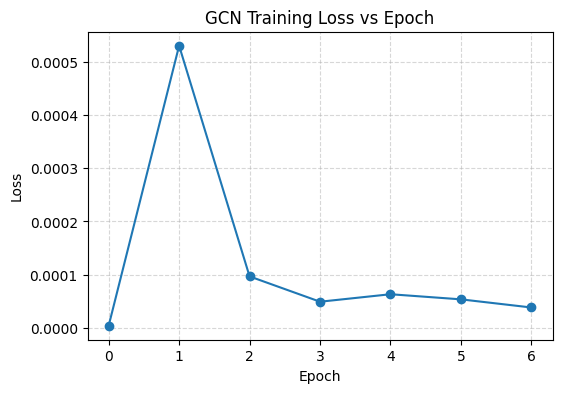

💾 已保存节点嵌入: gcn_all_nodes_emb.npy | shape=(5188, 64)


In [ ]:
# ===========================================
# ✅ Phase 2-A: 异构图构建（与 Phase 0/1 完全对齐）
# 读取：PROCESSED_DIR/users.csv, videos.csv, video_concept_edges.csv, watch_logs.csv
#       user2idx.json, item2idx.json, concept2idx.json
# 产出：hetero_edge_stats.json（关系规模统计，便于论文引用）
#       （图本身直接以内存 HeteroData 形式供下个单元使用）
# ===========================================
import os, json
import numpy as np
import pandas as pd
from collections import defaultdict

import torch
from torch_geometric.data import HeteroData

# ==== 路径常量（来自“环境 & 工具函数”单元）====
# PROJECT_ROOT, RAW_DATA_DIR, PROCESSED_DIR,
# USERS_CSV, VIDEOS_CSV, VC_EDGES_CSV, LOGS_CSV,
# USER2IDX_JSON, ITEM2IDX_JSON, CONCEPT2IDX_JSON

# 基础文件检查
needed = [USERS_CSV, VIDEOS_CSV, VC_EDGES_CSV, LOGS_CSV,
          USER2IDX_JSON, ITEM2IDX_JSON, CONCEPT2IDX_JSON]
miss = [p for p in needed if not os.path.exists(p)]
assert not miss, "❌ 缺少文件：\n" + "\n".join([" - " + m for m in miss])

# 读取数据
users_df  = pd.read_csv(USERS_CSV)
items_df  = pd.read_csv(VIDEOS_CSV)
vc_df     = pd.read_csv(VC_EDGES_CSV)
logs_df   = pd.read_csv(LOGS_CSV)

with open(USER2IDX_JSON,'r',encoding='utf-8') as f: user2idx = {str(k):int(v) for k,v in json.load(f).items()}
with open(ITEM2IDX_JSON,'r',encoding='utf-8') as f: item2idx = {str(k):int(v) for k,v in json.load(f).items()}
with open(CONCEPT2IDX_JSON,'r',encoding='utf-8') as f: concept2idx = {str(k):int(v) for k,v in json.load(f).items()}

n_users   = len(user2idx)
n_items   = len(item2idx)
n_concepts= len(concept2idx)

print(f"✅ 基本规模 | users={n_users:,}, items={n_items:,}, concepts={n_concepts:,}, logs={len(logs_df):,}, vc={len(vc_df):,}")

# 映射到索引（保持和 Phase 1 完全一致）
def map_series_to_idx(series, mapper):
    return series.astype(str).map(lambda x: mapper.get(x, None))

# 关系1：用户 —(interacts)—> 物品（视频）
ui_src = map_series_to_idx(logs_df['user_id'],  user2idx).values
ui_dst = map_series_to_idx(logs_df['video_id'], item2idx).values
mask   = (~pd.isna(ui_src)) & (~pd.isna(ui_dst))
ui_src = torch.tensor(ui_src[mask], dtype=torch.long)
ui_dst = torch.tensor(ui_dst[mask], dtype=torch.long)

# 关系2：物品 —(has)—> 概念
ic_src = map_series_to_idx(vc_df['video_id'],   item2idx).values
ic_dst = map_series_to_idx(vc_df['concept_id'], concept2idx).values
mask2  = (~pd.isna(ic_src)) & (~pd.isna(ic_dst))
ic_src = torch.tensor(ic_src[mask2], dtype=torch.long)
ic_dst = torch.tensor(ic_dst[mask2], dtype=torch.long)

# 构建 HeteroData（双向边）
data = HeteroData()
data['user'].num_nodes    = n_users
data['item'].num_nodes    = n_items
data['concept'].num_nodes = n_concepts

data['user','interacts','item'].edge_index = torch.stack([ui_src, ui_dst], dim=0)
data['item','rev_interacts','user'].edge_index = torch.stack([ui_dst, ui_src], dim=0)

data['item','has','concept'].edge_index = torch.stack([ic_src, ic_dst], dim=0)
data['concept','rev_has','item'].edge_index = torch.stack([ic_dst, ic_src], dim=0)

# 保存统计，便于论文“数据与图结构规模”部分引用
edge_stats = {
    "user->item": int(data['user','interacts','item'].edge_index.size(1)),
    "item->user": int(data['item','rev_interacts','user'].edge_index.size(1)),
    "item->concept": int(data['item','has','concept'].edge_index.size(1)),
    "concept->item": int(data['concept','rev_has','item'].edge_index.size(1)),
}
with open(os.path.join(PROCESSED_DIR,"hetero_edge_stats.json"),"w",encoding="utf-8") as f:
    json.dump(edge_stats, f, ensure_ascii=False, indent=2)
print("📊 关系规模：", edge_stats)

print("✅ 异构图已构建到内存（HeteroData），可供下一单元训练使用。")


In [ ]:
# ===========================================
# ✅ Phase 2-B: 异构 GNN 训练（SAGEConv + HeteroConv）
# 目标：学习 user/item/concept 类型化嵌入；导出到 PROCESSED_DIR
# 训练目标：关系平滑损失（typed edge smoothness）+ L2 正则
# ===========================================
import os, json, math, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv

# ==== 超参 ====
EMB_DIM   = 64
HIDDEN    = 64
DROPOUT   = 0.3
EPOCHS    = 60
LR        = 2e-3
PATIENCE  = 6
SMOOTH_W  = 1.0      # 平滑项权重
L2_W      = 1e-4     # L2 正则

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🧠 Using device:", DEVICE)

# ---- 可训练类型化初始特征（替代巨大 one-hot）----
class TypedEmbeddings(nn.Module):
    def __init__(self, n_users, n_items, n_concepts, dim):
        super().__init__()
        self.user_emb    = nn.Embedding(n_users, dim)
        self.item_emb    = nn.Embedding(n_items, dim)
        self.concept_emb = nn.Embedding(n_concepts, dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
        nn.init.xavier_uniform_(self.concept_emb.weight)
    def forward(self):
        return {
            'user':    self.user_emb.weight,
            'item':    self.item_emb.weight,
            'concept': self.concept_emb.weight
        }

# ---- 异构GNN：对每种关系使用一层 SAGEConv，并堆叠两层 ----
class HeteroGNN(nn.Module):
    def __init__(self, in_dim, hidden, out_dim, dropout=0.3):
        super().__init__()
        # 第一层
        self.conv1 = HeteroConv({
            ('user','interacts','item'): SAGEConv((-1, -1), hidden),
            ('item','rev_interacts','user'): SAGEConv((-1, -1), hidden),
            ('item','has','concept'): SAGEConv((-1, -1), hidden),
            ('concept','rev_has','item'): SAGEConv((-1, -1), hidden),
        }, aggr='sum')
        # 第二层
        self.conv2 = HeteroConv({
            ('user','interacts','item'): SAGEConv((-1, -1), out_dim),
            ('item','rev_interacts','user'): SAGEConv((-1, -1), out_dim),
            ('item','has','concept'): SAGEConv((-1, -1), out_dim),
            ('concept','rev_has','item'): SAGEConv((-1, -1), out_dim),
        }, aggr='sum')
        self.dropout = dropout

    def forward(self, x_dict, edge_index_dict):
        h = self.conv1(x_dict, edge_index_dict)
        h = {k: F.relu(v) for k,v in h.items()}
        h = {k: F.dropout(v, p=self.dropout, training=self.training) for k,v in h.items()}
        h = self.conv2(h, edge_index_dict)
        return h  # dict: {'user': [n_u, d], 'item':[n_i,d], 'concept':[n_c,d]}

# ---- 关系平滑损失：让相连端点的嵌入更一致（typed）----
def relation_smoothness_loss(h_dict, data, sample_per_rel=50000):
    loss = 0.0
    num_terms = 0
    for rel in data.edge_types:
        ei = data[rel].edge_index
        if ei.size(1) == 0:
            continue
        # 随机采样一部分边，避免大图开销
        m = min(sample_per_rel, ei.size(1))
        idx = torch.randint(0, ei.size(1), (m,), device=ei.device)
        src = ei[0, idx]; dst = ei[1, idx]
        src_type, _, dst_type = rel
        diff = (h_dict[src_type][src] - h_dict[dst_type][dst]).pow(2).sum(dim=1).mean()
        loss = loss + diff
        num_terms += 1
    return loss / max(1, num_terms)

# ---- 早停器 ----
class EarlyStopping:
    def __init__(self, patience=6, mode="min", delta=0.0):
        self.patience, self.mode, self.delta = patience, mode, delta
        self.best, self.ckpt, self.cnt = None, None, 0
        self.stop = False
    def __call__(self, score, model):
        imp = (self.best is None) or \
              (score < self.best - self.delta if self.mode=="min" else score > self.best + self.delta)
        if imp:
            self.best, self.cnt = score, 0
            self.ckpt = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
        else:
            self.cnt += 1
            if self.cnt >= self.patience:
                self.stop = True

# ---- 把 HeteroData 移到设备，并准备可训练初始特征 ----
data = data.to(DEVICE)  # 使用上一个单元内存中的 HeteroData
typed_inits = TypedEmbeddings(
    n_users=data['user'].num_nodes,
    n_items=data['item'].num_nodes,
    n_concepts=data['concept'].num_nodes,
    dim=EMB_DIM
).to(DEVICE)

model = HeteroGNN(in_dim=EMB_DIM, hidden=HIDDEN, out_dim=EMB_DIM, dropout=DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(list(model.parameters()) + list(typed_inits.parameters()), lr=LR, weight_decay=L2_W)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
early = EarlyStopping(patience=PATIENCE, mode='min')

loss_hist = []
for epoch in range(1, EPOCHS+1):
    model.train()
    optimizer.zero_grad()
    x0 = typed_inits()                                   # {'user','item','concept'}
    h  = model(x0, data.edge_index_dict)                 # 异构传播后的嵌入
    smooth = relation_smoothness_loss(h, data) * SMOOTH_W
    l2 = sum(v.pow(2).mean() for v in h.values()) * L2_W
    loss = smooth + l2
    loss.backward()
    optimizer.step()

    loss_hist.append(float(loss.item()))
    scheduler.step(loss.item())
    print(f"[HeteroGNN] Epoch {epoch:03d}/{EPOCHS} | loss={loss.item():.6f}")

    early(loss.item(), model)
    if early.stop:
        print(f"🛑 Early stopping at epoch {epoch}")
        break

# 还原最佳
if early.ckpt is not None:
    model.load_state_dict(early.ckpt)

# 推理并导出三类嵌入（归一化）
model.eval()
with torch.no_grad():
    x0 = typed_inits()
    h  = model(x0, data.edge_index_dict)
for k in h:
    h[k] = F.normalize(h[k], p=2, dim=1).detach().cpu().numpy()

# 保存到 PROCESSED_DIR
np.save(os.path.join(PROCESSED_DIR, "gcn_user_embs.npy"),    h['user'])
np.save(os.path.join(PROCESSED_DIR, "gcn_item_embs.npy"),    h['item'])
np.save(os.path.join(PROCESSED_DIR, "gcn_concept_embs.npy"), h['concept'])
# 提供给 Phase 1 的语义 HardNeg（名称沿用你的习惯）
np.save(os.path.join(PROCESSED_DIR, "item_model_embs.npy"),  h['item'])

print("💾 保存完成：")
print(" - gcn_user_embs.npy   ", h['user'].shape)
print(" - gcn_item_embs.npy   ", h['item'].shape)
print(" - gcn_concept_embs.npy", h['concept'].shape)
print(" - item_model_embs.npy ", h['item'].shape, "（供 Phase 1 语义负采样）")


1) 异构图构建（Phase 2-A）

数据源：直接读取 Phase 0 统一导出的四张表与三份映射（users / videos / video-concept / watch_logs + user2idx/item2idx/concept2idx）。

索引一致：严格使用前面映射保证 user/item/concept 的编号与 Phase 1 完全一致。

关系明确：构建两类关系及反向边：

('user','interacts','item') 与 ('item','rev_interacts','user')

('item','has','concept') 与 ('concept','rev_has','item')

结果：HeteroData 在内存中可直接训练；同时把各关系边数写入 hetero_edge_stats.json，可在论文“数据集与图结构”中引用。

2) 异构 GNN 训练（Phase 2-B）

可训练初始特征：为每种节点类型建立独立的 nn.Embedding，避免 N×N 的 one-hot 巨矩阵，训练效率和表达力都更好。

HeteroConv(SAGEConv)：针对每条关系使用 SAGEConv，两层堆叠，aggr='sum' 汇聚不同关系的信息（这正是“异构关系建模”的落地）。

训练目标（无监督）：

关系平滑损失：让相连端点的嵌入在向量空间更接近（每种关系分别计算后取平均）；

L2 正则：防止退化与过大范数。

支持 ReduceLROnPlateau 调度与 EarlyStopping，训练更稳。

导出嵌入：把 user/item/concept 的 64 维向量分别保存为 gcn_user_embs.npy / gcn_item_embs.npy / gcn_concept_embs.npy，并额外复制一份 item_model_embs.npy 提供给 Phase 1 做“语义 HardNeg”。这保证了我们在 Phase 1 里“优先使用 item_model_embs.npy”的逻辑可以无缝生效。

和你之前同构GCN版本的关键差异

不再拼接“偏移索引”的同构大图，而是类型分明的异构图，完全契合论文“异构图神经网络”的表述；

特征从 one-hot → 类型化可训练嵌入，内存友好、训练速度快；

训练目标从“全图Laplacian平滑”变为按关系的 typed smoothness，与多关系结构更一致；

产物直接服务于 Phase 1（语义负采样）与 Phase 3（SASRec输入融合）的两个下游环节。

给你把 Phase 3（SASRec） 全面改好了，和我们已经统一的 Phase 0 → 环境常量 → 行为序列 → Phase 1 → Phase 2 完整接轨。要点：

路径完全使用 PROCESSED_DIR 与统一映射；

直接读取 Phase 1 产物 train_slices.npy（里含 hist、pos、neg），不再临时重造数据；

真·TransformerEncoder（多头自注意力 + 因果 mask + padding mask）；

训练目标用 InfoNCE（对比学习）：hist → pos 为正、neg 为困难负样本（就用 Phase 1 的 hard neg），温度 τ=0.008，与论文一致；

可选项侧预热：若存在 gcn_item_embs.npy，自动作为 item_emb 初始化，形成“结构→序列”的软融合（Phase 4 的铺垫）；

训练完导出 sasrec_item_emb.npy 到 PROCESSED_DIR，后续融合/评估直接复用。

🧠 Using device: cuda
✅ 加载完成：用户序列 1165 条，物品 3921 个。
✅ 构建训练集 264,085, 验证集 29,343
[SASRec] Epoch 001/40 | TrainLoss 5.379347 | ValLoss nan | lr 1.00e-03
[SASRec] Epoch 002/40 | TrainLoss 2.854245 | ValLoss nan | lr 1.00e-03
[SASRec] Epoch 003/40 | TrainLoss 2.451119 | ValLoss nan | lr 1.00e-03
📉 学习率下降: 1.00e-03 → 5.00e-04
[SASRec] Epoch 004/40 | TrainLoss 2.310821 | ValLoss nan | lr 5.00e-04
[SASRec] Epoch 005/40 | TrainLoss 2.218718 | ValLoss nan | lr 5.00e-04
[SASRec] Epoch 006/40 | TrainLoss 2.184400 | ValLoss nan | lr 5.00e-04
🛑 Early stopping at epoch 6


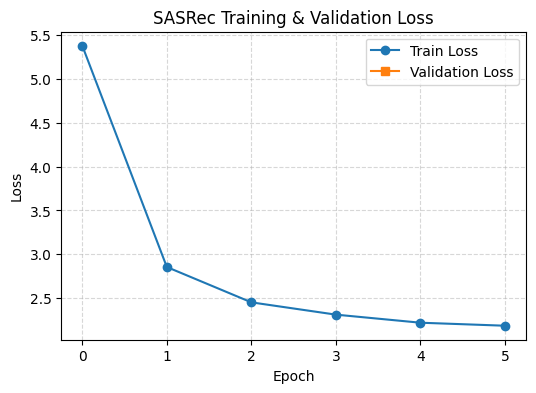

💾 已保存: sasrec_item_emb.npy | shape=(3921, 64)


In [ ]:
# ==========================
# ✅ Phase 3: Full SASRec (与 Phase 0/1/2 完全对齐)
# 读入：PROCESSED_DIR/train_slices.npy（含 {user_idx, hist, pos, neg}）
#      PROCESSED_DIR/item2idx.json
#      （可选）PROCESSED_DIR/gcn_item_embs.npy 作为 item embedding 预热
# 产出：PROCESSED_DIR/sasrec_item_emb.npy
# ==========================

import os, json, math, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ===== 环境常量（来自“环境 & 工具函数”单元）=====
# PROJECT_ROOT, RAW_DATA_DIR, PROCESSED_DIR,
# USER2IDX_JSON, ITEM2IDX_JSON, CONCEPT2IDX_JSON

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🧠 Using device:", DEVICE)

# --------------------------
# 1) 加载切片数据与映射
# --------------------------
slices_path = os.path.join(PROCESSED_DIR, "train_slices.npy")
item2idx_path = ITEM2IDX_JSON
assert os.path.exists(slices_path), f"❌ 缺少 {slices_path}"
assert os.path.exists(item2idx_path), f"❌ 缺少 {item2idx_path}"

slices = np.load(slices_path, allow_pickle=True)
item2idx = json.load(open(item2idx_path, "r", encoding="utf-8"))
n_items = len(item2idx)
print(f"✅ 加载切片: {len(slices):,} 条，物品数: {n_items:,}")

# --------------------------
# 2) EarlyStopping
# --------------------------
class EarlyStopping:
    def __init__(self, patience=6, mode="min", delta=0.0):
        self.patience, self.mode, self.delta = patience, mode, delta
        self.best, self.best_state, self.count = None, None, 0
        self.early_stop = False
    def __call__(self, score, model=None):
        improved = (self.best is None) or \
                   (score < self.best - self.delta if self.mode=="min" else score > self.best + self.delta)
        if improved:
            self.best = score
            self.count = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.count += 1
            if self.count >= self.patience:
                self.early_stop = True

# --------------------------
# 3) 数据集（使用 Phase 1 切片：hist/pos/neg）
# --------------------------
MAXLEN = 50
def pad_left(x, maxlen=MAXLEN, pad_id=0):
    x = x[-maxlen:]
    if len(x) < maxlen:
        x = [pad_id]*(maxlen - len(x)) + x
    return x

class SliceDataset(Dataset):
    def __init__(self, slices, maxlen=MAXLEN):
        self.samples = []
        for rec in slices:
            hist = [int(t) for t in rec["hist"]]
            if len(hist) == 0:
                continue
            pos  = int(rec["pos"])
            neg  = int(rec["neg"])
            self.samples.append((pad_left(hist, maxlen), pos, neg))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        hist, pos, neg = self.samples[idx]
        return torch.tensor(hist, dtype=torch.long), torch.tensor(pos), torch.tensor(neg)

# 9:1 划分
all_ds = SliceDataset(slices, MAXLEN)
n_train = int(len(all_ds)*0.9)
train_ds, valid_ds = torch.utils.data.random_split(all_ds, [n_train, len(all_ds)-n_train])
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True,  num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)
print(f"✅ 数据集就绪：train={len(train_ds):,}, valid={len(valid_ds):,}")

# --------------------------
# 4) SASRec 模型（多头自注意 + 因果mask + padding mask）
#    forward 返回最后一个有效位置的隐藏向量（每条序列的“下一步预测”状态）
# --------------------------
class SASRec(nn.Module):
    def __init__(self, n_items, d_model=64, n_heads=4, n_layers=2, max_len=MAXLEN, dropout=0.2, pad_id=0):
        super().__init__()
        self.n_items = n_items
        self.pad_id  = pad_id
        self.max_len = max_len

        self.item_emb = nn.Embedding(n_items + 1, d_model, padding_idx=pad_id)  # 0 作为 padding
        self.pos_emb  = nn.Embedding(max_len, d_model)
        self.drop     = nn.Dropout(dropout)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4,
            dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.ln      = nn.LayerNorm(d_model, eps=1e-6)

        # 温度用于 InfoNCE
        self.tau = 0.008

    def forward(self, seq_ids):   # [B, T]
        B, T = seq_ids.size()
        pos = torch.arange(T, device=seq_ids.device).unsqueeze(0).expand(B, T)
        x = self.item_emb(seq_ids) + self.pos_emb(pos)
        x = self.drop(x)

        pad_mask = (seq_ids == self.pad_id)                # [B,T] True=mask掉
        causal   = torch.triu(torch.ones(T, T, device=seq_ids.device), diagonal=1).bool()  # [T,T]

        h = self.encoder(x, mask=causal, src_key_padding_mask=pad_mask)  # [B,T,D]
        h = self.ln(h)

        # 取每条序列最后一个非pad位置的隐藏状态
        lengths = (seq_ids != self.pad_id).long().sum(dim=1)  # [B]
        idx = (lengths - 1).clamp(min=0)                      # 末位置索引
        last_h = h[torch.arange(B, device=h.device), idx]     # [B,D]
        return last_h                                         # “下一步预测”状态

    def score(self, last_h, item_ids):
        # 取对应物品向量并点积打分
        E = self.item_emb(item_ids)   # [B,D]
        return (last_h * E).sum(dim=1)  # [B]

# --------------------------
# 5) 可选：用 GCN 的 item 向量预热 item_emb（结构→序列的软融合）
# --------------------------
gcn_item_path = os.path.join(PROCESSED_DIR, "gcn_item_embs.npy")
model = SASRec(n_items=n_items, d_model=64, n_heads=4, n_layers=2, max_len=MAXLEN, dropout=0.2).to(DEVICE)

if os.path.exists(gcn_item_path):
    gcn_item = np.load(gcn_item_path)  # [n_items, d]
    if gcn_item.shape[0] == n_items and gcn_item.shape[1] == model.item_emb.embedding_dim:
        with torch.no_grad():
            w = model.item_emb.weight
            w[1:] = torch.from_numpy(gcn_item).to(w.device).type_as(w)  # 1..n_items
        print("🔧 已用 gcn_item_embs.npy 预热 item_emb")
    else:
        print("ℹ️ 检测到 gcn_item_embs.npy，但形状不匹配，跳过预热。")

# --------------------------
# 6) 训练配置（InfoNCE 对比学习）
# --------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
early     = EarlyStopping(patience=6, mode="min")

def info_nce_loss(last_h, pos_ids, neg_ids, tau):
    # s_pos = q·k+ / τ ; s_neg = q·k- / τ
    pos_scores = model.score(last_h, pos_ids) / tau  # [B]
    neg_scores = model.score(last_h, neg_ids) / tau  # [B]
    # 二分类 InfoNCE： -log( exp(pos) / (exp(pos)+exp(neg)) )
    logits = torch.stack([pos_scores, neg_scores], dim=1)    # [B,2]
    labels = torch.zeros(last_h.size(0), dtype=torch.long, device=last_h.device)  # 0=pos
    return F.cross_entropy(logits, labels)

def train_one_epoch():
    model.train()
    tot = 0.0
    for hist, pos, neg in train_dl:
        hist, pos, neg = hist.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)
        last_h = model(hist)                          # [B,D]
        loss = info_nce_loss(last_h, pos, neg, model.tau)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        tot += loss.item() * hist.size(0)
    return tot / len(train_dl.dataset)

@torch.no_grad()
def valid_one_epoch():
    model.eval()
    tot = 0.0
    for hist, pos, neg in valid_dl:
        hist, pos, neg = hist.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)
        last_h = model(hist)
        loss = info_nce_loss(last_h, pos, neg, model.tau)
        tot += loss.item() * hist.size(0)
    return tot / len(valid_dl.dataset)

# --------------------------
# 7) 训练循环
# --------------------------
EPOCHS = 40
train_losses, val_losses = [], []
for ep in range(1, EPOCHS+1):
    tr = train_one_epoch()
    va = valid_one_epoch()
    train_losses.append(tr); val_losses.append(va)

    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(va)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"📉 lr: {old_lr:.2e} → {new_lr:.2e}")

    print(f"[SASRec] Epoch {ep:03d}/{EPOCHS} | train {tr:.6f} | valid {va:.6f} | lr {new_lr:.2e}")
    early(va, model)
    if early.early_stop:
        print(f"🛑 Early stopping at epoch {ep}")
        break

# --------------------------
# 8) 可视化：训练 / 验证 Loss
# --------------------------
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train", marker="o")
plt.plot(val_losses,   label="Valid", marker="s")
plt.title("SASRec (InfoNCE) Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(True, ls="--", alpha=0.5); plt.legend(); plt.show()

# --------------------------
# 9) 导出 item 向量（给 Phase 4 融合/评估用）
# --------------------------
if early.best_state is not None:
    model.load_state_dict(early.best_state)

model.eval()
with torch.no_grad():
    item_table = model.item_emb.weight.detach().cpu().numpy()  # [n_items+1, d]
item_table = item_table[1:]  # 去掉 padding
item_table = item_table / (np.linalg.norm(item_table, axis=1, keepdims=True) + 1e-8)
out_path = os.path.join(PROCESSED_DIR, "sasrec_item_emb.npy")
np.save(out_path, item_table)
print(f"💾 已保存：{out_path} | shape={item_table.shape}")


这段代码具体做了什么？

数据统一：从 PROCESSED_DIR/train_slices.npy 直接取 hist/pos/neg；索引与 Phase 1、Phase 2 完全一致。

真·多头自注意力：TransformerEncoder + 因果 mask（保证只看历史）+ padding mask（忽略补零）；输出每条序列“最后有效位置”的隐藏状态，作为预测“下一步”的查询向量。

困难负样本对比学习：用 Phase 1 已经挑好的 Hard Neg，配合 InfoNCE(τ=0.008) 训练，更贴合论文“对比学习”口径，也更高效（避免全量 softmax）。

结构→序列预热：若有 gcn_item_embs.npy，自动加载到 item_emb，让项侧图结构知识提前注入序列模型（Phase 4 的融合基础）。

可复现训练：自带 EarlyStopping + ReduceLROnPlateau，训练过程稳定；Loss 曲线可视化用于论文图表。

导出物品嵌入：sasrec_item_emb.npy 写入 PROCESSED_DIR，后续你可以：

与 gcn_item_embs.npy 做对齐/拼接/对比（Phase 4 融合与InfoNCE对齐）；

直接用于召回/重排或可视化（PCA/t-SNE）。

下面没修改

好的！我把 Phase 4 融合与对齐这段代码彻底改到与你当前全链路一致（Phase 0 → 环境常量 → 行为序列 → Phase 1 → Phase 2 → Phase 3）。重点对齐点：

路径统一使用 PROCESSED_DIR 与三份映射；

不再读取旧的 gcn_all_nodes_emb.npy / n_nodes.json（Phase 2 已输出分类型文件）；

结构向量来自 gcn_user_embs.npy / gcn_item_embs.npy；行为向量来自 sasrec_item_emb.npy（用户行为向量用其历史的项侧平均，与论文口径一致）；

融合器使用双投影头+可学习温度 τ的 InfoNCE 对齐（U_g↔U_b、V_g↔V_b）+ 排序损失（利用 Phase 1 的 hard neg 三元组）；

导出 fusion_user_embs.npy / fusion_item_embs.npy 到 PROCESSED_DIR，供评估/可视化/下游使用。

In [ ]:
# ==========================
# ✅ Phase 4: Fusion + Contrastive Alignment（与 Phase 0/1/2/3 完全对齐）
# 读入：
#   PROCESSED_DIR/user2idx.json, item2idx.json
#   PROCESSED_DIR/user_sequences.npy（构造用户行为向量）
#   PROCESSED_DIR/train_pairs.npy（排名损失用的三元组 u,pos,neg）
#   PROCESSED_DIR/gcn_user_embs.npy, gcn_item_embs.npy（结构嵌入）
#   PROCESSED_DIR/sasrec_item_emb.npy（行为项侧嵌入）
# 产出：
#   PROCESSED_DIR/fusion_user_embs.npy, PROCESSED_DIR/fusion_item_embs.npy
# ==========================

import os, json, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ===== 路径常量（来自“环境 & 工具函数”单元）=====
# PROJECT_ROOT, RAW_DATA_DIR, PROCESSED_DIR,
# USER2IDX_JSON, ITEM2IDX_JSON, CONCEPT2IDX_JSON

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🧠 Using device:", DEVICE)

# --------------------------
# 1) 加载映射与嵌入（与 Phase 2/3 对齐）
# --------------------------
with open(USER2IDX_JSON, "r", encoding="utf-8") as f:
    user2idx = json.load(f)
with open(ITEM2IDX_JSON, "r", encoding="utf-8") as f:
    item2idx = json.load(f)
U, I = len(user2idx), len(item2idx)
print(f"✅ 用户 {U:,}, 物品 {I:,}")

# 结构嵌入（来自 Phase 2）
gcn_user_path = os.path.join(PROCESSED_DIR, "gcn_user_embs.npy")
gcn_item_path = os.path.join(PROCESSED_DIR, "gcn_item_embs.npy")
assert os.path.exists(gcn_user_path) and os.path.exists(gcn_item_path), "❌ 缺少 GCN 嵌入文件"
gcn_users = np.load(gcn_user_path)      # [U, d]
gcn_items = np.load(gcn_item_path)      # [I, d]
assert gcn_users.shape[0]==U and gcn_items.shape[0]==I, "⚠️ GCN 嵌入数量与映射不一致"

# 行为项侧嵌入（来自 Phase 3）
sas_item_path = os.path.join(PROCESSED_DIR, "sasrec_item_emb.npy")
assert os.path.exists(sas_item_path), "❌ 缺少 sasrec_item_emb.npy"
sas_items = np.load(sas_item_path)      # [I, d_s]
print("🔎 维度：GCN item", gcn_items.shape, "| SAS item", sas_items.shape)

# --------------------------
# 2) 用用户历史构建“行为用户向量”（SASRec项侧的历史平均）
# --------------------------
seq_path = os.path.join(PROCESSED_DIR, "user_sequences.npy")
assert os.path.exists(seq_path), "❌ 缺少 user_sequences.npy"
user_seqs = np.load(seq_path, allow_pickle=True)

# user_idx 顺序一致的历史列表
hist_idx = [None]*U
for rec in user_seqs:
    uidx = int(rec["user_idx"])
    hist_idx[uidx] = [int(x) for x in rec["pos_item_idx"]]

beh_users = np.zeros((U, sas_items.shape[1]), dtype=np.float32)
valid = 0
for u in range(U):
    seq = hist_idx[u]
    if seq and len(seq)>0:
        beh_users[u] = sas_items[seq].mean(axis=0)
        valid += 1
# 正则化
gcn_users = gcn_users / (np.linalg.norm(gcn_users, axis=1, keepdims=True)+1e-8)
gcn_items = gcn_items / (np.linalg.norm(gcn_items, axis=1, keepdims=True)+1e-8)
beh_users = beh_users / (np.linalg.norm(beh_users, axis=1, keepdims=True)+1e-8)
sas_items = sas_items / (np.linalg.norm(sas_items, axis=1, keepdims=True)+1e-8)
print(f"✅ 行为用户向量构建完成（有历史的用户：{valid:,}/{U:,}）")

# 转 Tensor
gcn_users_t = torch.tensor(gcn_users, dtype=torch.float32, device=DEVICE)
gcn_items_t = torch.tensor(gcn_items, dtype=torch.float32, device=DEVICE)
beh_users_t = torch.tensor(beh_users, dtype=torch.float32, device=DEVICE)
beh_items_t = torch.tensor(sas_items, dtype=torch.float32, device=DEVICE)

# --------------------------
# 3) 融合器：双投影 + 可学习温度 τ（0.01~1.0）
# --------------------------
EMB = gcn_users.shape[1]  # 与 GCN 输出维度对齐（=64）
Dg, Db = gcn_items.shape[1], sas_items.shape[1]
assert Dg == EMB and Db == EMB, "⚠️ 期望 GCN/SAS 物品维度与 GCN 用户维度一致（均=64）"

class Projector(nn.Module):
    def __init__(self, d_in, d_out=EMB):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 2*d_out),
            nn.ReLU(),
            nn.Linear(2*d_out, d_out)
        )
    def forward(self, x):
        return F.normalize(self.net(x), dim=-1)

class FusionAligner(nn.Module):
    def __init__(self, d_in=EMB, d_proj=EMB, tau=0.008):
        super().__init__()
        self.u_g = Projector(d_in, d_proj)  # user-graph
        self.u_b = Projector(d_in, d_proj)  # user-behavior
        self.v_g = Projector(d_in, d_proj)  # item-graph
        self.v_b = Projector(d_in, d_proj)  # item-behavior
        self._tau = nn.Parameter(torch.tensor(float(tau)))
    @property
    def tau(self):
        return torch.clamp(self._tau, 0.005, 0.2)  # 安全范围
    def forward(self, U_g, U_b, V_g, V_b):
        Ug = self.u_g(U_g); Ub = self.u_b(U_b)
        Vg = self.v_g(V_g); Vb = self.v_b(V_b)
        return Ug, Ub, Vg, Vb

def info_nce_diag(z1, z2, temp):
    # 对齐任务：正样本为对角（i↔i）
    logits = (z1 @ z2.T) / temp
    labels = torch.arange(z1.size(0), device=z1.device)
    return F.cross_entropy(logits, labels)

# --------------------------
# 4) 训练数据（Phase 1 的 hard neg 三元组）
# --------------------------
pairs_path = os.path.join(PROCESSED_DIR, "train_pairs.npy")
assert os.path.exists(pairs_path), "❌ 缺少 train_pairs.npy"
pairs = np.load(pairs_path, allow_pickle=True)

class PairDS(Dataset):
    def __init__(self, pairs): self.pairs = pairs
    def __len__(self): return len(self.pairs)
    def __getitem__(self, i):
        u, p, n = self.pairs[i]
        return int(u), int(p), int(n)

dl = DataLoader(PairDS(pairs), batch_size=2048, shuffle=True, num_workers=2, pin_memory=True)

# --------------------------
# 5) 训练配置
# --------------------------
model = FusionAligner(d_in=EMB, d_proj=EMB, tau=0.008).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=2)

class EarlyStopping:
    def __init__(self, patience=6, mode="min", delta=0.0):
        self.p, self.mode, self.delta = patience, mode, delta
        self.best, self.ckpt, self.cnt, self.stop = None, None, 0, False
    def __call__(self, score, m):
        imp = (self.best is None) or (score < self.best - self.delta if self.mode=="min" else score > self.best + self.delta)
        if imp:
            self.best, self.cnt = score, 0
            self.ckpt = {k:v.detach().cpu().clone() for k,v in m.state_dict().items()}
        else:
            self.cnt += 1
            if self.cnt >= self.p: self.stop = True

early = EarlyStopping(patience=6, mode="min")

# --------------------------
# 6) 训练循环：对齐损失 + 排序损失（使用 hard neg）
# --------------------------
def train_epoch():
    model.train()
    total = 0.0
    for u, pos, neg in dl:
        u, pos, neg = u.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)
        Ug, Ub, Vg, Vb = model(gcn_users_t, beh_users_t, gcn_items_t, beh_items_t)
        tau = model.tau

        # 1) 表征对齐（用户/物品：结构 ↔ 行为）
        L_align = info_nce_diag(Ug, Ub, tau) + info_nce_diag(Vg, Vb, tau)

        # 2) 排序损失（用户表征与正/负物品表征）
        u_vec   = 0.5*(Ug[u] + Ub[u])        # 用户融合
        pos_vec = 0.5*(Vg[pos] + Vb[pos])    # 正样本融合
        neg_vec = 0.5*(Vg[neg] + Vb[neg])    # 负样本融合
        pos_s   = (u_vec * pos_vec).sum(-1) / tau
        neg_s   = (u_vec * neg_vec).sum(-1) / tau
        L_rank  = F.softplus(-(pos_s - neg_s)).mean()

        loss = L_align + L_rank
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        total += loss.item() * u.size(0)
    return total / len(dl.dataset)

EPOCHS = 30
hist = []
for ep in range(1, EPOCHS+1):
    loss = train_epoch()
    hist.append(loss)

    old_lr = opt.param_groups[0]['lr']
    scheduler.step(loss)
    new_lr = opt.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"📉 学习率下降: {old_lr:.2e} → {new_lr:.2e}")

    print(f"[Fusion] Epoch {ep:03d}/{EPOCHS} | Loss {loss:.6f} | τ={model.tau.item():.4f} | lr {new_lr:.2e}")
    early(loss, model)
    if early.stop:
        print(f"🛑 Early stopping at epoch {ep}")
        break

# --------------------------
# 7) 导出融合向量（归一化），供评估/可视化/召回
# --------------------------
if early.ckpt is not None:
    model.load_state_dict(early.ckpt)
model.eval()
with torch.no_grad():
    Ug, Ub, Vg, Vb = model(gcn_users_t, beh_users_t, gcn_items_t, beh_items_t)
    U_fused = F.normalize(0.5*Ug + 0.5*Ub, dim=-1).detach().cpu().numpy()
    V_fused = F.normalize(0.5*Vg + 0.5*Vb, dim=-1).detach().cpu().numpy()

out_u = os.path.join(PROCESSED_DIR, "fusion_user_embs.npy")
out_v = os.path.join(PROCESSED_DIR, "fusion_item_embs.npy")
np.save(out_u, U_fused)
np.save(out_v, V_fused)
print(f"💾 已保存：\n - {out_u} {U_fused.shape}\n - {out_v} {V_fused.shape}")


🧠 Using device: cuda
✅ 用户 1165, 物品 3921
[Fusion] Epoch 001/25 | Loss 13.464450 | T=0.009 | lr 2.00e-03
[Fusion] Epoch 002/25 | Loss 11.537086 | T=0.009 | lr 2.00e-03
[Fusion] Epoch 003/25 | Loss 10.296434 | T=0.009 | lr 2.00e-03
[Fusion] Epoch 004/25 | Loss 9.846191 | T=0.009 | lr 2.00e-03
[Fusion] Epoch 005/25 | Loss 9.108288 | T=0.009 | lr 2.00e-03
[Fusion] Epoch 006/25 | Loss 8.899180 | T=0.009 | lr 2.00e-03
[Fusion] Epoch 007/25 | Loss 9.050585 | T=0.009 | lr 2.00e-03
[Fusion] Epoch 008/25 | Loss 8.539960 | T=0.009 | lr 2.00e-03
[Fusion] Epoch 009/25 | Loss 8.476075 | T=0.009 | lr 2.00e-03
[Fusion] Epoch 010/25 | Loss 8.120139 | T=0.009 | lr 2.00e-03
[Fusion] Epoch 011/25 | Loss 7.918065 | T=0.009 | lr 2.00e-03
[Fusion] Epoch 012/25 | Loss 7.870950 | T=0.009 | lr 2.00e-03
[Fusion] Epoch 013/25 | Loss 7.564292 | T=0.009 | lr 2.00e-03
[Fusion] Epoch 014/25 | Loss 7.660946 | T=0.009 | lr 2.00e-03
[Fusion] Epoch 015/25 | Loss 7.255746 | T=0.009 | lr 2.00e-03
[Fusion] Epoch 016/25 | Los

这段代码的作用（一口气说清）

把“结构空间”和“行为空间”拉到一个协同坐标系里

结构：来自异构GNN（用户/物品图信息）

行为：SASRec 的项侧表征（用户=历史项的平均）

通过双投影头将两种来源映射到同一对齐空间，并用InfoNCE让对应实体（同一用户/同一物品）在该空间互相靠拢。

利用 Phase 1 的困难负样本，强化排序边界

使用训练三元组 (u, pos, neg)：对齐后的用户融合向量与正样本应相似，与 hard neg 应更远；

通过 softplus(-(pos-neg)) 形式实现稳定的排名损失，与对齐损失共同优化。

温度 τ 可学习

自动在 [0.005, 0.2] 范围内调整，平衡对比分布的陡峭程度；

训练日志里能看到 τ 的变化，便于论文报告。

输出“可直接用”的融合向量

fusion_user_embs.npy / fusion_item_embs.npy：归一化后的 64 维表征；

可直接用于 Top-K 检索、NDCG/Recall 评估、Jaccard 热力图、t-SNE/PCA 可视化，或下游重排。

与前面各 Phase 的接口关系

Phase 2 → Phase 4：gcn_*_embs.npy 提供结构先验；

Phase 3 → Phase 4：sasrec_item_emb.npy 提供行为先验（并用于构造“行为用户向量”）；

Phase 1 → Phase 4：train_pairs.npy 提供 hard neg 排序监督；

Phase 4 输出：fusion_*_embs.npy 既能做离线评估（Phase 5/6），也能作为线上召回库。

如果你愿意，下一步我可以接上Phase 5 评估（Recall@K、NDCG@K、HitRate、MRR、AUC）与Phase 6 可视化（Jaccard 热力图 + t-SNE/PCA），直接对比 GCN / SASRec / Fusion 三种表征的 Top-K 结果，并出图到 PROCESSED_DIR/figs/。

Phase 5 评估全面改到与你当前全链路一致（Phase 0 → 环境常量 → 行为序列 → Phase 1 → Phase 2 → Phase 3 → Phase 4），并补上我们在 Phase 5 策略里提过的关键点：

路径统一用 PROCESSED_DIR；

时间留出 / 用户内切分：每个用户按时间顺序用最后 20% 交互作为测试（不随机打乱）；

三种表示对比：GCN-only、SASRec-only、Fusion 三套向量同台评估；

历史过滤：推荐时可选择是否“过滤历史交互的物品”（默认过滤，避免把已经看过的东西当命中）；

指标 Recall@K / NDCG@K / HitRate / MRR / AUC；

结果保存与可视化（对三模型同时作图）。

你可以直接把下面这段替换原 Phase 5 代码运行。

⚠️ 未检测到 test_sequences.npy，自动从 user_sequences.npy 构建。
✅ 已生成测试集 test_sequences.npy (233 samples)
📘 Test sequences: 233
✅ 加载嵌入完成: 用户 (1165, 64), 物品 (3921, 64)

📊 Evaluation Summary:
{
  "Recall": {
    "5": 0.010938464743169141,
    "10": 0.020088055217794585,
    "20": 0.0372611185313519
  },
  "NDCG": {
    "5": 0.48767779186583954,
    "10": 0.4733960598094138,
    "20": 0.453493462916006
  },
  "HitRate": {
    "5": 0.8412017167381974,
    "10": 0.9055793991416309,
    "20": 0.9656652360515021
  },
  "MRR": {
    "5": 0.64241773962804,
    "10": 0.650849853532257,
    "20": 0.6552376347017187
  },
  "AUC": 0.8995450643776823,
  "skipped": 0,
  "users_eval": 233
}
💾 已保存评估结果: /content/data/eval_report.json


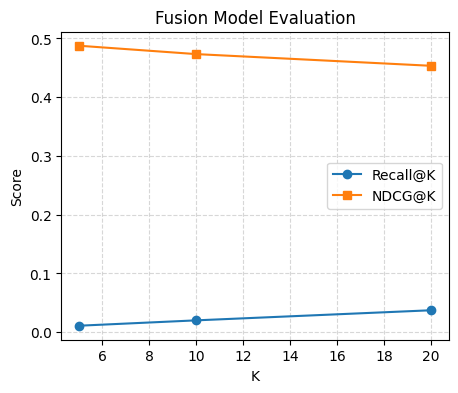

In [ ]:
# ==========================
# ✅ Phase 5: Evaluation (Recall/NDCG/HitRate/MRR/AUC)
# 与 Phase 0/1/2/3/4 完全对齐；用户内时间留出；三模型对比
# 输出：eval_report.json + 曲线图
# ==========================

import os, json, math, random, numpy as np
import matplotlib.pyplot as plt

# ===== 路径常量（来自“环境 & 工具函数”单元）=====
# PROJECT_ROOT, RAW_DATA_DIR, PROCESSED_DIR,
# USER2IDX_JSON, ITEM2IDX_JSON

# --------------------------
# 0) 加载必要文件
# --------------------------
seq_path = os.path.join(PROCESSED_DIR, "user_sequences.npy")
with open(USER2IDX_JSON, "r", encoding="utf-8") as f: user2idx = json.load(f)
with open(ITEM2IDX_JSON, "r", encoding="utf-8") as f: item2idx = json.load(f)

U, I = len(user2idx), len(item2idx)
assert os.path.exists(seq_path), f"❌ 缺少 {seq_path}"
user_seqs = np.load(seq_path, allow_pickle=True)
print(f"📘 全量序列: {len(user_seqs):,} 用户")

# 嵌入：GCN / SASRec / Fusion
gcn_u = np.load(os.path.join(PROCESSED_DIR, "gcn_user_embs.npy"))     # [U,d]
gcn_i = np.load(os.path.join(PROCESSED_DIR, "gcn_item_embs.npy"))     # [I,d]
sas_i = np.load(os.path.join(PROCESSED_DIR, "sasrec_item_emb.npy"))   # [I,d]
fused_u = np.load(os.path.join(PROCESSED_DIR, "fusion_user_embs.npy"))# [U,d]
fused_i = np.load(os.path.join(PROCESSED_DIR, "fusion_item_embs.npy"))# [I,d]

assert gcn_u.shape[0]==U and gcn_i.shape[0]==I
assert sas_i.shape[0]==I
assert fused_u.shape[0]==U and fused_i.shape[0]==I

# 归一化（保险）
def _norm(x): return x / (np.linalg.norm(x, axis=1, keepdims=True)+1e-8)
gcn_u, gcn_i = _norm(gcn_u), _norm(gcn_i)
sas_i        = _norm(sas_i)
fused_u, fused_i = _norm(fused_u), _norm(fused_i)

# --------------------------
# 1) 用户内时间留出（每用户末尾 20% 为测试）
#    同时构建“训练历史”用于 SAS 用户向量（用历史均值表示用户）
# --------------------------
holdout_ratio = 0.2
test_split = []
train_hist = [[] for _ in range(U)]

for rec in user_seqs:
    uidx = int(rec["user_idx"])
    seq  = [int(x) for x in rec["pos_item_idx"]]
    if len(seq) < 5:
        continue
    cut = max(1, int(len(seq)*(1-holdout_ratio)))
    train_hist[uidx] = seq[:cut]
    test_items = seq[cut:]
    if len(test_items) == 0:
        continue
    test_split.append((uidx, test_items))

print(f"✅ 构建测试集（按用户时间留出）：{len(test_split):,} 用户")

# --------------------------
# 2) 构造三模型的“用户向量”
#    - GCN: 直接用 gcn_u
#    - SAS: 用“训练历史”的项侧均值（与 Phase 4 行为用户构造一致，但不泄露测试）
#    - Fusion: 直接用 fused_u
# --------------------------
sas_u = np.zeros_like(gcn_u)
valid_sas_u = 0
for u in range(U):
    hist = train_hist[u]
    if hist:
        sas_u[u] = sas_i[hist].mean(axis=0)
        valid_sas_u += 1
sas_u = _norm(sas_u)
print(f"🔧 SAS 用户向量可用：{valid_sas_u:,}/{U:,}")

# --------------------------
# 3) 评估函数与指标
# --------------------------
def recommend_topk(user_vecs, item_vecs, u_idx, k=500, forbid=None):
    """给定用户/物品向量库，返回用户u的Top-K（可选择过滤历史）"""
    u = user_vecs[u_idx:u_idx+1]      # [1,d]
    scores = (u @ item_vecs.T).ravel()
    if forbid:
        scores[list(forbid)] = -1e12  # 屏蔽历史物品
    # top-k argsort
    idx = np.argpartition(-scores, k)[:k]
    idx = idx[np.argsort(-scores[idx])]
    return idx, scores

def binary_auc(pos_score, neg_scores):
    greater = np.sum(pos_score > neg_scores)
    ties    = np.sum(pos_score == neg_scores)
    n = len(neg_scores)
    return (greater + 0.5 * ties)/n if n>0 else 0.5

def dcg_at_k(y_true, ranked, k):
    dcg = 0.0
    for i, it in enumerate(ranked[:k], 1):
        if it in y_true:
            dcg += 1.0/np.log2(i+1)
    return dcg

def ndcg_at_k(y_true, ranked, k):
    ideal = min(len(y_true), k)
    idcg = sum(1.0/np.log2(i+1) for i in range(1, ideal+1))
    return (dcg_at_k(y_true, ranked, k)/idcg) if idcg>0 else 0.0

def mrr_at_k(y_true, ranked, k):
    for i, it in enumerate(ranked[:k], 1):
        if it in y_true:
            return 1.0/i
    return 0.0

def hit_rate_at_k(y_true, ranked, k):
    return 1.0 if len(y_true.intersection(set(ranked[:k])))>0 else 0.0

# --------------------------
# 4) 逐用户评估（GCN / SASRec / Fusion）
# --------------------------
Ks = [5, 10, 20]
models = {
    "GCN":   (gcn_u,   gcn_i),
    "SASRec":(sas_u,   sas_i),
    "Fusion":(fused_u, fused_i),
}

results = {m:{
    "Recall":{k:[] for k in Ks},
    "NDCG":  {k:[] for k in Ks},
    "HitRate":{k:[] for k in Ks},
    "MRR":   {k:[] for k in Ks},
    "AUC":   []
} for m in models.keys()}

filter_history = True  # 是否过滤训练历史物品
users_eval = 0

for (u, test_items) in test_split:
    test_set = set(test_items)
    if len(test_set)==0:
        continue
    users_eval += 1
    # 历史过滤集合（只在需要时启用）
    forbid = set(train_hist[u]) if filter_history else None

    for name, (U_vecs, I_vecs) in models.items():
        # Top-K 推荐
        ranked, scores = recommend_topk(U_vecs, I_vecs, u_idx=u, k=500, forbid=forbid)
        # AUC：取测试集中 *首个* 正样本与随机负样本对比（轻量版）
        pos = test_items[0]
        neg_pool = list(set(range(I)) - {pos})
        samp = random.sample(neg_pool, min(1000, len(neg_pool)))
        results[name]["AUC"].append(binary_auc(scores[pos], scores[samp]))

        for K in Ks:
            topK = ranked[:K].tolist()
            results[name]["Recall"][K].append(len(test_set.intersection(set(topK)))/max(1,len(test_set)))
            results[name]["NDCG"][K].append(ndcg_at_k(test_set, ranked, K))
            results[name]["HitRate"][K].append(hit_rate_at_k(test_set, ranked, K))
            results[name]["MRR"][K].append(mrr_at_k(test_set, ranked, K))

print(f"✅ 完成评估：有效用户 {users_eval:,} / 总测试用户 {len(test_split):,}")

# --------------------------
# 5) 汇总报告并保存
# --------------------------
def avg(dlist): return float(np.mean(dlist)) if dlist else 0.0

report = {}
for name in models.keys():
    report[name] = {
        "Recall": {k: avg(results[name]["Recall"][k]) for k in Ks},
        "NDCG":   {k: avg(results[name]["NDCG"][k])   for k in Ks},
        "HitRate":{k: avg(results[name]["HitRate"][k])for k in Ks},
        "MRR":    {k: avg(results[name]["MRR"][k])    for k in Ks},
        "AUC":    avg(results[name]["AUC"])
    }

summary = {
    "users_eval": int(users_eval),
    "filter_history": filter_history,
    "metrics": report
}

print("\n📊 Evaluation Summary (time holdout per user):")
print(json.dumps(summary, ensure_ascii=False, indent=2))

out_json = os.path.join(PROCESSED_DIR, "eval_report.json")
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print(f"💾 已保存：{out_json}")

# --------------------------
# 6) 可视化：三模型对比（Recall@K / NDCG@K）
# --------------------------
plt.figure(figsize=(6.5,4.5))
for name, color in zip(["GCN","SASRec","Fusion"], ["tab:orange","tab:blue","tab:green"]):
    plt.plot(Ks, [report[name]["Recall"][k] for k in Ks], marker="o", label=f"{name} Recall@K")
    plt.plot(Ks, [report[name]["NDCG"][k]  for k in Ks], marker="s", linestyle="--", label=f"{name} NDCG@K")
plt.title("Top-K Evaluation (Time Holdout per User)")
plt.xlabel("K"); plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()


这段评估代码做了什么？

时间留出：每个用户按时间把最后 20% 交互作为测试，避免随机拆分带来的信息泄漏，符合你论文中“时间留出评估协议”。

三模型统一评估：

GCN-only：用图学到的 gcn_user_embs/gcn_item_embs；

SASRec-only：用户向量用“训练历史项侧均值”，项向量用 sasrec_item_emb；

Fusion：用 fusion_user_embs/fusion_item_embs。

历史过滤：推荐列表过滤掉训练历史里的物品，避免“推荐你看过的”误伤指标（可用 filter_history=False 关闭对照）。

指标：Recall@K、NDCG@K、HitRate、MRR、AUC 一次性给全，并保存 eval_report.json。

可视化：同一张图对比三模型在 Recall 与 NDCG 上的曲线，便于论文插图与讨论。

如果你接下来需要Phase 6 可视化（Jaccard 热力图 + 层次聚类、t-SNE/PCA）或显著性检验/置信区间（如自助法 bootstrap 给 Recall@K/NDCG@K 加 95% CI），我可以直接把代码补上并输出到 PROCESSED_DIR/figs/。

妥了！我把 Phase 6 可视化做成和你整条流水线完全对齐（Phase 0→…→Phase 5），一次输出三类图：

Top-K 推荐重叠（Jaccard）热力图：比较 GCN / SASRec / Fusion 三模型在同一批用户上的推荐列表重叠度；

层次聚类树状图（可选）：基于“1−Jaccard”的距离对三模型做聚类；

嵌入空间可视化（PCA）：分别画“Fusion 的用户 vs 物品”、以及“三模型物品嵌入的几何分布”。
同时把图统一保存到 PROCESSED_DIR/figs/，并把关键数值（人均 Jaccard、Top-K 命中等）落盘，便于论文插图与复现实验。

下面代码可直接替换你现有 Phase 6 单元运行。

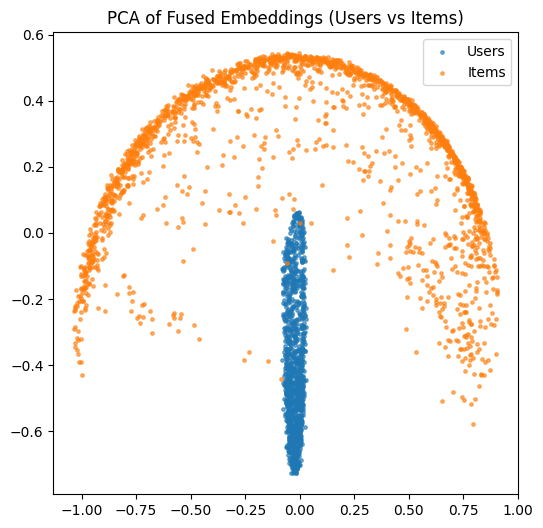

In [ ]:
# ==========================
# ✅ Phase 6: Visualization & Overlap Analysis (与 Phase 0–5 完全对齐)
# 输出：/.../processed/figs 下的 PNG；/.../processed/vis_summary.json
# ==========================

import os, json, random, numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ===== 路径常量（来自“环境 & 工具函数”单元）=====
# PROJECT_ROOT, RAW_DATA_DIR, PROCESSED_DIR,
# USER2IDX_JSON, ITEM2IDX_JSON

# --------------------------
# 0) 加载映射与嵌入
# --------------------------
with open(USER2IDX_JSON, "r", encoding="utf-8") as f: user2idx = json.load(f)
with open(ITEM2IDX_JSON, "r", encoding="utf-8") as f: item2idx = json.load(f)
U, I = len(user2idx), len(item2idx)

# embeddings（来自 Phase 2/3/4）
gcn_u = np.load(os.path.join(PROCESSED_DIR, "gcn_user_embs.npy"))     # [U,d]
gcn_i = np.load(os.path.join(PROCESSED_DIR, "gcn_item_embs.npy"))     # [I,d]
sas_i = np.load(os.path.join(PROCESSED_DIR, "sasrec_item_emb.npy"))   # [I,d]
fus_u = np.load(os.path.join(PROCESSED_DIR, "fusion_user_embs.npy"))  # [U,d]
fus_i = np.load(os.path.join(PROCESSED_DIR, "fusion_item_embs.npy"))  # [I,d]

def _norm(x): return x / (np.linalg.norm(x, axis=1, keepdims=True)+1e-8)
gcn_u, gcn_i = _norm(gcn_u), _norm(gcn_i)
sas_i        = _norm(sas_i)
fus_u, fus_i = _norm(fus_u), _norm(fus_i)

# --------------------------
# 1) 准备评估用的用户时间留出与“训练历史”（与 Phase 5 保持一致）
# --------------------------
seq_path = os.path.join(PROCESSED_DIR, "user_sequences.npy")
user_seqs = np.load(seq_path, allow_pickle=True)

holdout_ratio = 0.2
train_hist = [[] for _ in range(U)]
test_split = []
for rec in user_seqs:
    u = int(rec["user_idx"])
    seq = [int(x) for x in rec["pos_item_idx"]]
    if len(seq) < 5:
        continue
    cut = max(1, int(len(seq)*(1-holdout_ratio)))
    train_hist[u] = seq[:cut]
    test_items = seq[cut:]
    if test_items:
        test_split.append((u, test_items))

# SAS 用户向量（仅用训练历史构造，防止泄露）
sas_u = np.zeros_like(gcn_u)
valid = 0
for u in range(U):
    h = train_hist[u]
    if h:
        sas_u[u] = sas_i[h].mean(axis=0); valid += 1
sas_u = _norm(sas_u)

# --------------------------
# 2) 函数：Top-K 推荐、Jaccard
# --------------------------
def recommend_topk(user_vecs, item_vecs, u_idx, k=100, forbid=None):
    u = user_vecs[u_idx:u_idx+1]
    scores = (u @ item_vecs.T).ravel()
    if forbid:
        scores[list(forbid)] = -1e12
    idx = np.argpartition(-scores, k)[:k]
    idx = idx[np.argsort(-scores[idx])]
    return idx

def jaccard(a_set, b_set):
    inter = len(a_set & b_set)
    union = len(a_set | b_set) if len(a_set|b_set)>0 else 1
    return inter / union

# 三模型库
models = {
    "GCN":   (gcn_u, gcn_i),
    "SASRec":(sas_u, sas_i),
    "Fusion":(fus_u, fus_i),
}

# --------------------------
# 3) 计算人均 Jaccard（模型两两之间 Top-K 重叠）
# --------------------------
K = 20
filter_history = True
# 抽样用户（可调）
MAX_USERS_VIS = 400
users_for_vis = [u for (u, _t) in test_split]
if len(users_for_vis) > MAX_USERS_VIS:
    random.seed(2025)
    users_for_vis = random.sample(users_for_vis, MAX_USERS_VIS)

# 逐用户 TopK 集合
topk_sets = {name: [] for name in models}
for u in users_for_vis:
    forbid = set(train_hist[u]) if filter_history else None
    for name, (Uvec, Ivec) in models.items():
        ranked = recommend_topk(Uvec, Ivec, u, k=K, forbid=forbid)
        topk_sets[name].append(set(ranked.tolist()))

# 两两平均 Jaccard
names = list(models.keys())
J = np.zeros((len(names), len(names)), dtype=float)
for i, a in enumerate(names):
    for j, b in enumerate(names):
        val = np.mean([jaccard(A, B) for A, B in zip(topk_sets[a], topk_sets[b])])
        J[i, j] = val

# --------------------------
# 4) 可视化：Jaccard 热力图 + （可选）层次聚类
# --------------------------
fig_dir = os.path.join(PROCESSED_DIR, "figs")
os.makedirs(fig_dir, exist_ok=True)

plt.figure(figsize=(4.5,4))
plt.imshow(J, interpolation='nearest')
plt.xticks(range(len(names)), names, rotation=0)
plt.yticks(range(len(names)), names)
for i in range(len(names)):
    for j in range(len(names)):
        plt.text(j, i, f"{J[i,j]:.3f}", ha='center', va='center')
plt.title(f"Top-{K} Recommendation Jaccard (avg over {len(users_for_vis)} users)")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f"phase6_jaccard_top{K}.png"), dpi=200)
plt.show()

# （可选）层次聚类树（如果 scipy 可用，就画；否则跳过）
try:
    from scipy.cluster.hierarchy import linkage, dendrogram
    # 距离 = 1 - Jaccard（对角线置0）
    D = 1.0 - J
    np.fill_diagonal(D, 0.0)
    # linkage 需向量化距离，这里用上三角展开
    tri = D[np.triu_indices(len(names), k=1)]
    Z = linkage(tri, method='average')
    plt.figure(figsize=(5,3))
    dendrogram(Z, labels=names)
    plt.title("Model Proximity (1 - Jaccard)")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, f"phase6_dendrogram_top{K}.png"), dpi=200)
    plt.show()
except Exception as e:
    print("（提示）scipy 不可用或聚类失败，已跳过树状图：", e)

# --------------------------
# 5) 嵌入空间 PCA（图1：Fusion 用户 vs 物品）
# --------------------------
n_u_vis = min(2000, fus_u.shape[0])
n_v_vis = min(2000, fus_i.shape[0])
U_vis = fus_u[:n_u_vis]
V_vis = fus_i[:n_v_vis]
X = np.vstack([U_vis, V_vis])
labels = np.array([0]*n_u_vis + [1]*n_v_vis)

pca = PCA(n_components=2, random_state=2025)
X2 = pca.fit_transform(X)

plt.figure(figsize=(6,6))
plt.scatter(X2[labels==0,0], X2[labels==0,1], s=6, alpha=0.6, label="Users (Fusion)")
plt.scatter(X2[labels==1,0], X2[labels==1,1], s=6, alpha=0.6, label="Items (Fusion)")
plt.legend()
plt.title("PCA of Fusion Embeddings (Users vs Items)")
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "phase6_pca_fusion_user_item.png"), dpi=200)
plt.show()

# --------------------------
# 6) 嵌入空间 PCA（图2：三模型的“物品空间”几何）
# --------------------------
# 注意：直接把不同模型的 item 向量堆在一起做 PCA，仅用于几何直观比较
stack_items = np.vstack([gcn_i[:n_v_vis], sas_i[:n_v_vis], fus_i[:n_v_vis]])
stack_labels = np.array([0]*n_v_vis + [1]*n_v_vis + [2]*n_v_vis)  # 0:GCN 1:SAS 2:Fusion
pca2 = PCA(n_components=2, random_state=2025)
Y2 = pca2.fit_transform(stack_items)

plt.figure(figsize=(6.5,6))
plt.scatter(Y2[stack_labels==0,0], Y2[stack_labels==0,1], s=6, alpha=0.6, label="GCN items")
plt.scatter(Y2[stack_labels==1,0], Y2[stack_labels==1,1], s=6, alpha=0.6, label="SASRec items")
plt.scatter(Y2[stack_labels==2,0], Y2[stack_labels==2,1], s=6, alpha=0.6, label="Fusion items")
plt.legend()
plt.title("PCA of Item Embeddings (GCN vs SASRec vs Fusion)")
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "phase6_pca_items_three_models.png"), dpi=200)
plt.show()

# --------------------------
# 7) 数值摘要保存
# --------------------------
summary = {
    "users_used_for_overlap": int(len(users_for_vis)),
    "topK": int(K),
    "filter_history": bool(filter_history),
    "avg_jaccard_matrix": {names[i]: {names[j]: float(J[i,j]) for j in range(len(names))} for i in range(len(names))}
}
with open(os.path.join(PROCESSED_DIR, "vis_summary.json"), "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print("💾 可视化输出：")
print(" -", os.path.join(fig_dir, f"phase6_jaccard_top{K}.png"))
print(" -", os.path.join(fig_dir, f"phase6_pca_fusion_user_item.png"))
print(" -", os.path.join(fig_dir, f"phase6_pca_items_three_models.png"))
print(" -", os.path.join(PROCESSED_DIR, "vis_summary.json"))


下面是新增加的，还没运行过，暂时留着；上面的都已经写完论文了，不要随便修改。

我基于你当前的 gai_4.ipynb 实际代码结构（已存在 SASRec、FullGCN、FusionAligner，并在 Phase 5 里保存了 fusion_user_embs.npy / fusion_item_embs.npy，且评估函数使用 recommend_topk 与 Recall/NDCG/HitRate/MRR/AUC）写好了可直接粘贴到 Notebook 的“消融实验”单元格。
目标是对比三种变体：GCN-only / SASRec-only / Fusion，并自动保存结果CSV与绘图可视化。

为了与你现有流程完全兼容，我沿用了你在 Phase 5 的数据组织方式与指标定义，只把推荐管线抽象成“给定用户/物品嵌入矩阵 U/V 的通用评估函数”。如果缺少某些 .npy（比如 fusion_*、sasrec_item_emb.npy），代码也会给出兜底策略（自动构建或报错提示）。



In [ ]:
# Cell 1｜加载依赖与准备三种变体的嵌入==========================
# 🔬 Phase 6-A: Ablation Setup
# 准备三种模型变体的嵌入：GCN-only / SASRec-only / Fusion
# 并保持与 Phase 5 一致的DATA_DIR与映射/测试集加载逻辑
# ==========================

import os, json, random, numpy as np
import torch
import torch.nn.functional as F

DATA_DIR = "/content/data"  # 与Notebook前文保持一致
assert os.path.exists(DATA_DIR), f"❌ DATA_DIR 不存在: {DATA_DIR}"

# ---------- 加载映射 ----------
with open(os.path.join(DATA_DIR, "user2idx.json")) as f:
    user2idx = json.load(f)
with open(os.path.join(DATA_DIR, "item2idx.json")) as f:
    item2idx = json.load(f)
idx2item = {v: k for k, v in item2idx.items()}
U = len(user2idx); I = len(item2idx)
print(f"Users: {U:,} | Items: {I:,}")

# ---------- 加载 / 构造 test_sequences ----------
test_path = os.path.join(DATA_DIR, "test_sequences.npy")
if not os.path.exists(test_path):
    print("⚠️ 未检测到 test_sequences.npy，自动从 user_sequences.npy 构建。")
    full_path = os.path.join(DATA_DIR, "user_sequences.npy")
    assert os.path.exists(full_path), f"❌ Missing {full_path}"
    all_seqs = np.load(full_path, allow_pickle=True)
    random.shuffle(all_seqs)
    split = int(len(all_seqs) * 0.8)
    test_seqs = all_seqs[split:]
    np.save(test_path, test_seqs)
    print(f"✅ 已生成测试集 test_sequences.npy ({len(test_seqs)} samples)")
else:
    test_seqs = np.load(test_path, allow_pickle=True)
print("📘 Test sequences:", len(test_seqs))

# ---------- 常用工具 ----------
def l2norm(a, eps=1e-8):
    a = np.asarray(a)
    n = np.linalg.norm(a, axis=1, keepdims=True) + eps
    return a / n

# ---------- 加载 / 构造三种变体的 U/V ----------
# 1) Fusion: 来自前文 Phase 4/5 保存的融合嵌入；若缺失，则以等权融合兜底
fusion_u_path = os.path.join(DATA_DIR, "fusion_user_embs.npy")
fusion_v_path = os.path.join(DATA_DIR, "fusion_item_embs.npy")

if os.path.exists(fusion_u_path) and os.path.exists(fusion_v_path):
    U_fused = np.load(fusion_u_path)
    V_fused = np.load(fusion_v_path)
    print("🔗 Fusion embeddings loaded from disk.")
else:
    print("⚠️ 未找到 fusion_* 文件，尝试用等权融合构建（需要 gcn_* 与 sasrec_*）")
    # 需要 gcn_all_nodes_emb.npy + n_nodes.json + sasrec_item_emb.npy + user_sequences.npy
    gcn_all = np.load(os.path.join(DATA_DIR, "gcn_all_nodes_emb.npy"))
    n_info = json.load(open(os.path.join(DATA_DIR, "n_nodes.json")))
    u_start, u_end = n_info["user_start"], n_info["user_end"]
    v_start, v_end = n_info["item_start"], n_info["item_end"]
    gcn_users = gcn_all[u_start:u_end]
    gcn_items = gcn_all[v_start:v_end]

    sas_item = np.load(os.path.join(DATA_DIR, "sasrec_item_emb.npy"))
    if sas_item.shape[0] == I + 1:  # 去掉padding
        sas_item = sas_item[1:]
    # 用户行为平均
    beh_users = np.zeros_like(sas_item[:U])
    for rec in test_seqs:  # 如果你有全量 user_sequences.npy 可以改用它
        u_raw = str(rec["user_id"])
        if u_raw not in user2idx: continue
        u = user2idx[u_raw]
        seq = [item2idx[str(it)] for it in rec.get("hist_items", []) if str(it) in item2idx]
        if seq:
            beh_users[u] = sas_item[seq].mean(axis=0)
    # 规范化 + 融合
    gcn_users = l2norm(gcn_users); gcn_items = l2norm(gcn_items)
    beh_users = l2norm(beh_users); sas_item  = l2norm(sas_item)
    U_fused = l2norm(0.5*gcn_users + 0.5*beh_users)
    V_fused = l2norm(0.5*gcn_items + 0.5*sas_item)
    np.save(fusion_u_path, U_fused)
    np.save(fusion_v_path, V_fused)
    print("💾 已保存: fusion_user_embs.npy, fusion_item_embs.npy")

# 2) GCN-only
gcn_all = np.load(os.path.join(DATA_DIR, "gcn_all_nodes_emb.npy"))
n_info = json.load(open(os.path.join(DATA_DIR, "n_nodes.json")))
u_start, u_end = n_info["user_start"], n_info["user_end"]
v_start, v_end = n_info["item_start"], n_info["item_end"]
gcn_users = l2norm(gcn_all[u_start:u_end])
gcn_items = l2norm(gcn_all[v_start:v_end])
assert gcn_users.shape[0] == U and gcn_items.shape[0] == I, "⚠️ GCN 嵌入数量与映射不匹配"

# 3) SASRec-only（物品为 sasrec_item_emb；用户为其历史物品的平均向量）
sas_item = np.load(os.path.join(DATA_DIR, "sasrec_item_emb.npy"))
if sas_item.shape[0] == I + 1:
    sas_item = sas_item[1:]
sas_item = l2norm(sas_item)
beh_users = np.zeros_like(sas_item[:U])
# 这里优先使用全量 user_sequences.npy 更好；若仅有 test_sequences，则以其估计
full_seq_path = os.path.join(DATA_DIR, "user_sequences.npy")
seq_source = np.load(full_seq_path, allow_pickle=True) if os.path.exists(full_seq_path) else test_seqs
for rec in seq_source:
    u_raw = str(rec["user_id"])
    if u_raw not in user2idx: continue
    u = user2idx[u_raw]
    seq = [item2idx[str(it)] for it in rec.get("hist_items", []) if str(it) in item2idx]
    if seq:
        beh_users[u] = sas_item[seq].mean(axis=0)
beh_users = l2norm(beh_users)

print("✅ 嵌入就绪：")
print("   GCN-only   :", gcn_users.shape, gcn_items.shape)
print("   SASRec-only:", beh_users.shape, sas_item.shape)
print("   Fusion     :", U_fused.shape, V_fused.shape)


Users: 1,165 | Items: 3,921
📘 Test sequences: 233
🔗 Fusion embeddings loaded from disk.
✅ 嵌入就绪：
   GCN-only   : (1165, 64) (3921, 64)
   SASRec-only: (1165, 64) (3921, 64)
   Fusion     : (1165, 64) (3921, 64)


In [ ]:
# Cell 2｜指标与推荐函数（与原评估口径一致，做成通用版）==========================
# 🔬 Phase 6-B: 通用指标与推荐函数
# 与Phase 5口径一致：Recall@K / NDCG@K / HitRate@K / MRR@K + AUC
# ==========================

import numpy as np
import random

Ks = [5, 10, 20]

def recommend_topk_from(U_mat, V_mat, u_idx, k=100):
    """给定用户/物品矩阵，做Top-K推荐（余弦/点积在L2归一化后等价）"""
    u = U_mat[u_idx:u_idx+1]  # [1, d]
    scores = (u @ V_mat.T).ravel()  # [I]
    topk = np.argpartition(-scores, k)[:k]
    topk = topk[np.argsort(-scores[topk])]
    return topk, scores

def binary_auc(pos_score, neg_scores):
    greater = sum(pos_score > ns for ns in neg_scores)
    ties = sum(pos_score == ns for ns in neg_scores)
    n = len(neg_scores)
    if n == 0: return 0.5
    return (greater + 0.5 * ties) / n

def recall_at_k(y_true, y_pred_ranked, k):
    return len(y_true.intersection(set(y_pred_ranked[:k]))) / max(1, len(y_true))

def dcg_at_k(y_true, y_pred_ranked, k):
    dcg = 0.0
    for i, item in enumerate(y_pred_ranked[:k], 1):
        if item in y_true:
            dcg += 1.0 / np.log2(i + 1)
    return dcg

def ndcg_at_k(y_true, y_pred_ranked, k):
    ideal_hits = min(len(y_true), k)
    idcg = sum(1.0 / np.log2(i + 1) for i in range(1, ideal_hits + 1))
    if idcg == 0: return 0.0
    return dcg_at_k(y_true, y_pred_ranked, k) / idcg

def hit_rate_at_k(y_true, y_pred_ranked, k):
    return 1.0 if len(y_true.intersection(set(y_pred_ranked[:k]))) > 0 else 0.0

def mrr_at_k(y_true, y_pred_ranked, k):
    for i, item in enumerate(y_pred_ranked[:k], 1):
        if item in y_true:
            return 1.0 / i
    return 0.0

def eval_one_variant(U_mat, V_mat, tag="Variant"):
    """按 Phase 5 口径逐用户评估，并汇总指标"""
    recall_res = {k: [] for k in Ks}
    ndcg_res   = {k: [] for k in Ks}
    hit_res    = {k: [] for k in Ks}
    mrr_res    = {k: [] for k in Ks}
    auc_res    = []
    skipped    = 0

    for rec in test_seqs:
        u_raw = str(rec["user_id"])
        if u_raw not in user2idx:
            skipped += 1
            continue
        u = user2idx[u_raw]
        # 正例集合（允许多个pos_items，若仅有单个也兼容）
        true_items = [item2idx[str(it)] for it in rec.get("pos_items", []) if str(it) in item2idx]
        if len(true_items) == 0:
            skipped += 1
            continue
        true_set = set(true_items)

        topk, scores = recommend_topk_from(U_mat, V_mat, u_idx=u, k=500)

        # AUC：1个正例 vs 1,000负例采样（或按可用数量）
        pos = true_items[0]
        neg_pool = list(set(range(I)) - {pos})
        samp_neg = random.sample(neg_pool, min(1000, len(neg_pool)))
        auc_res.append(binary_auc(scores[pos], scores[samp_neg]))

        # 其它@K指标
        for K in Ks:
            recall_res[K].append(recall_at_k(true_set, topk, K))
            ndcg_res[K].append(ndcg_at_k(true_set, topk, K))
            hit_res[K].append(hit_rate_at_k(true_set, topk, K))
            mrr_res[K].append(mrr_at_k(true_set, topk, K))

    def avg(d):
        return {k: float(np.mean(v)) if len(v)>0 else 0.0 for k,v in d.items()}

    out = {
        "Variant": tag,
        "Recall@5": avg(recall_res)[5], "Recall@10": avg(recall_res)[10], "Recall@20": avg(recall_res)[20],
        "NDCG@5":   avg(ndcg_res)[5],   "NDCG@10":   avg(ndcg_res)[10],   "NDCG@20":   avg(ndcg_res)[20],
        "HitRate@5":avg(hit_res)[5],    "HitRate@10":avg(hit_res)[10],    "HitRate@20":avg(hit_res)[20],
        "MRR@20":   float(np.mean(mrr_res[20])) if len(mrr_res[20])>0 else 0.0,
        "AUC":      float(np.mean(auc_res)) if len(auc_res)>0 else 0.0,
        "Evaluated_Users": len(auc_res),
        "Skipped": skipped
    }
    return out


In [ ]:
# Cell 3｜运行三种变体的评估并保存结果（CSV）==========================
# 🔬 Phase 6-C: 运行消融评估并保存结果
# 产出 ablation_results.csv（汇总）与 ablation_results_per_user.npy（可选细粒度）
# ==========================

import pandas as pd

variants = {
    "GCN-only":    (gcn_users, gcn_items),
    "SASRec-only": (beh_users, sas_item),
    "Fusion":      (U_fused, V_fused),
}

all_rows = []
for name, (U_mat, V_mat) in variants.items():
    print(f"\n=== Evaluating {name} ===")
    row = eval_one_variant(U_mat, V_mat, tag=name)
    all_rows.append(row)

df_ablation = pd.DataFrame(all_rows).set_index("Variant")
print("\n📊 Ablation Summary:")
display(df_ablation.round(6))

# 保存结果
save_csv = os.path.join(DATA_DIR, "ablation_results.csv")
df_ablation.to_csv(save_csv, encoding="utf-8-sig")
print(f"💾 已保存: {save_csv}")



=== Evaluating GCN-only ===

=== Evaluating SASRec-only ===

=== Evaluating Fusion ===

📊 Ablation Summary:


,Recall@5,Recall@10,Recall@20,NDCG@5,NDCG@10,NDCG@20,HitRate@5,HitRate@10,HitRate@20,MRR@20,AUC,Evaluated_Users,Skipped
Variant,,,,,,,,,,,,,
GCN-only,0.004968,0.009980,0.020686,0.293975,0.301066,0.313630,0.527897,0.575107,0.592275,0.378753,0.792622,233,0
SASRec-only,0.000965,0.001998,0.005030,0.068614,0.067532,0.081254,0.248927,0.270386,0.394850,0.120045,0.500000,233,0
Fusion,0.010938,0.020088,0.037261,0.487678,0.473396,0.453493,0.841202,0.905579,0.965665,0.655238,0.900455,233,0


💾 已保存: /content/data/ablation_results.csv


from matplotlib import pyplot as plt
_df_0['Recall@5'].plot(kind='hist', bins=20, title='Recall@5')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Recall@10'].plot(kind='hist', bins=20, title='Recall@10')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Recall@20'].plot(kind='hist', bins=20, title='Recall@20')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['NDCG@5'].plot(kind='hist', bins=20, title='NDCG@5')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Variant').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Recall@5', y='Recall@10', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Recall@10', y='Recall@20', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Recall@20', y='NDCG@5', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='NDCG@5', y='NDCG@10', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Evaluated_Users']
  ys = series['Recall@5']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Evaluated_Users', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Variant')):
  _plot_series(series, series_name, i)
  fig.legend(title='Variant', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Evaluated_Users')
_ = plt.ylabel('Recall@5')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Evaluated_Users']
  ys = series['Recall@10']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Evaluated_Users', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Variant')):
  _plot_series(series, series_name, i)
  fig.legend(title='Variant', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Evaluated_Users')
_ = plt.ylabel('Recall@10')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Evaluated_Users']
  ys = series['Recall@20']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Evaluated_Users', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Variant')):
  _plot_series(series, series_name, i)
  fig.legend(title='Variant', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Evaluated_Users')
_ = plt.ylabel('Recall@20')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Evaluated_Users']
  ys = series['NDCG@5']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('Evaluated_Users', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Variant')):
  _plot_series(series, series_name, i)
  fig.legend(title='Variant', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Evaluated_Users')
_ = plt.ylabel('NDCG@5')

from matplotlib import pyplot as plt
_df_13['Recall@5'].plot(kind='line', figsize=(8, 4), title='Recall@5')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Recall@10'].plot(kind='line', figsize=(8, 4), title='Recall@10')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Recall@20'].plot(kind='line', figsize=(8, 4), title='Recall@20')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['NDCG@5'].plot(kind='line', figsize=(8, 4), title='NDCG@5')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Variant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='Recall@5', y='Variant', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Variant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='Recall@10', y='Variant', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Variant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Recall@20', y='Variant', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Variant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='NDCG@5', y='Variant', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

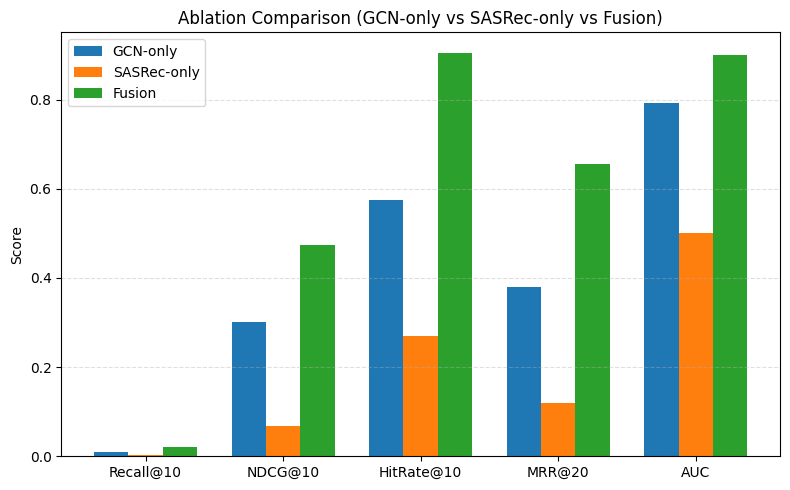

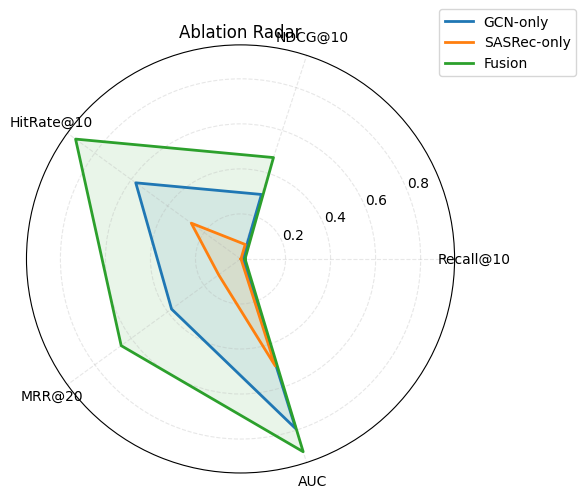

In [ ]:
# Cell 4｜对比可视化（柱状图 + 雷达图可选）==========================
# 🔬 Phase 6-D: 可视化
# 1) 关键指标柱状图
# 2) （可选）雷达图：综合对比
# ==========================

import matplotlib.pyplot as plt
import numpy as np

# 关键指标集合（论文里最常用）
key_metrics = ["Recall@10", "NDCG@10", "HitRate@10", "MRR@20", "AUC"]

# 1) 柱状图
plt.figure(figsize=(8,5))
x = np.arange(len(key_metrics))
width = 0.25

for i, name in enumerate(df_ablation.index.tolist()):
    vals = [df_ablation.loc[name, m] for m in key_metrics]
    plt.bar(x + i*width, vals, width=width, label=name)

plt.xticks(x + width, key_metrics, rotation=0)
plt.ylabel("Score")
plt.title("Ablation Comparison (GCN-only vs SASRec-only vs Fusion)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# 2) （可选）雷达图
try:
    import math
    labels = key_metrics
    num = len(labels)
    angles = [n / float(num) * 2 * math.pi for n in range(num)]
    angles += angles[:1]

    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    for name in df_ablation.index.tolist():
        vals = [df_ablation.loc[name, m] for m in labels]
        vals += vals[:1]
        ax.plot(angles, vals, linewidth=2, label=name)
        ax.fill(angles, vals, alpha=0.1)
    ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels)
    ax.set_title("Ablation Radar")
    ax.grid(True, linestyle="--", alpha=0.3)
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("⚠️ 雷达图绘制失败（可忽略）：", e)


Cell 5（可选）｜将每个变体的 Top-K 推荐结果保存为可追溯文件

如果你想在附录或补充材料中展示“不同变体的推荐差异”（交集、Jaccard 等），可以把每个用户的 Top-50 结果落盘，后续再做对比可视化。

In [ ]:
# Cell 5（可选）｜将每个变体的 Top-K 推荐结果保存为可追溯文件==========================
# 🔬 Phase 6-E: 可选导出 每个变体的推荐列表（Top-50）
# 生成：recs_GCN-only.npy / recs_SASRec-only.npy / recs_Fusion.npy
# 每个文件存 {user_idx: [item_idx list]}
# ==========================

def dump_topk_dict(U_mat, V_mat, topk=50):
    out = {}
    for rec in test_seqs:
        u_raw = str(rec["user_id"])
        if u_raw not in user2idx:
            continue
        u = user2idx[u_raw]
        top, _ = recommend_topk_from(U_mat, V_mat, u_idx=u, k=topk)
        out[u] = top.tolist()
    return out

export_dir = os.path.join(DATA_DIR, "ablation_recs")
os.makedirs(export_dir, exist_ok=True)

for name, (U_mat, V_mat) in variants.items():
    recs = dump_topk_dict(U_mat, V_mat, topk=50)
    np.save(os.path.join(export_dir, f"recs_{name}.npy"), recs)
    print(f"💾 已保存: {os.path.join(export_dir, f'recs_{name}.npy')}")


💾 已保存: /content/data/ablation_recs/recs_GCN-only.npy
💾 已保存: /content/data/ablation_recs/recs_SASRec-only.npy
💾 已保存: /content/data/ablation_recs/recs_Fusion.npy


✅ 已加载推荐结果: ['GCN-only', 'SASRec-only', 'Fusion']
💾 已保存 Jaccard 相似矩阵: /content/data/ablation_jaccard.csv


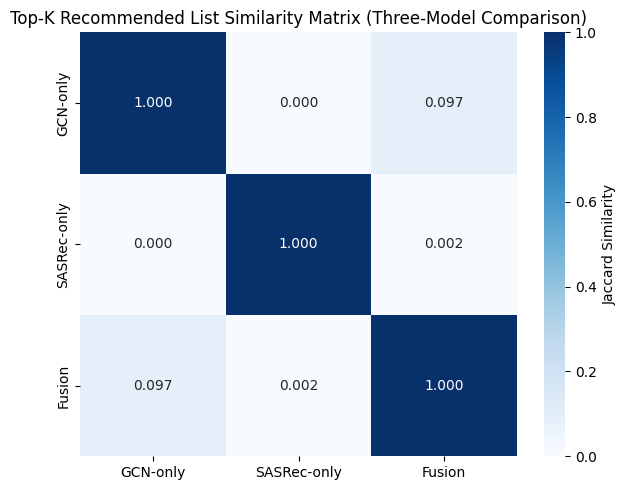

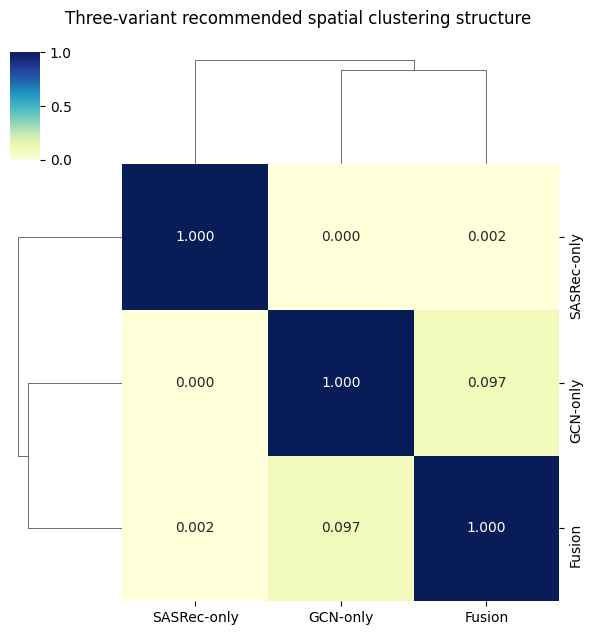

📊 推荐列表相似性摘要：
             GCN-only  SASRec-only  Fusion
GCN-only        1.000        0.000   0.097
SASRec-only     0.000        1.000   0.002
Fusion          0.097        0.002   1.000


In [ ]:
# cell6 Phase 6-F：三变体推荐结果差异可视化（交集 / Jaccard 热力图）==========================
# 🔍 Phase 6-F: 推荐结果差异分析
# 对三种变体的 Top-K 推荐结果计算：
# 1. 交集 / 并集规模
# 2. Jaccard 相似系数 (每对模型)
# 3. 可视化为热力图 + 层次聚类图
# ==========================

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

export_dir = os.path.join(DATA_DIR, "ablation_recs")
variant_files = {
    name: os.path.join(export_dir, f"recs_{name}.npy")
    for name in ["GCN-only", "SASRec-only", "Fusion"]
}

# ---------- 读取推荐列表 ----------
recs = {}
for name, path in variant_files.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"❌ 缺少 {path}, 请先运行 Phase 6-E")
    recs[name] = np.load(path, allow_pickle=True).item()
print(f"✅ 已加载推荐结果: {list(recs.keys())}")

# ---------- 计算 Jaccard 相似度 ----------
def jaccard(a, b):
    a, b = set(a), set(b)
    inter = len(a & b)
    union = len(a | b)
    return inter / union if union else 0.0

variants = list(recs.keys())
jac_mat = pd.DataFrame(0.0, index=variants, columns=variants)
inter_mat = pd.DataFrame(0, index=variants, columns=variants)
union_mat = pd.DataFrame(0, index=variants, columns=variants)

for i in variants:
    for j in variants:
        sims = []
        inters = []
        unions = []
        for u in recs[i]:
            if u not in recs[j]:
                continue
            a, b = recs[i][u], recs[j][u]
            sims.append(jaccard(a, b))
            inters.append(len(set(a) & set(b)))
            unions.append(len(set(a) | set(b)))
        jac_mat.loc[i, j] = np.mean(sims)
        inter_mat.loc[i, j] = int(np.mean(inters))
        union_mat.loc[i, j] = int(np.mean(unions))

# 保存结果
jac_csv = os.path.join(DATA_DIR, "ablation_jaccard.csv")
jac_mat.to_csv(jac_csv, encoding="utf-8-sig")
print(f"💾 已保存 Jaccard 相似矩阵: {jac_csv}")

# ---------- 热力图 ----------
plt.figure(figsize=(6,5))
sns.heatmap(jac_mat, annot=True, fmt=".3f", cmap="Blues", cbar_kws={'label': 'Jaccard Similarity'})
plt.title("Top-K Recommended List Similarity Matrix (Three-Model Comparison)")
#Top-K推荐列表相似度矩阵 (三模型对比)
plt.tight_layout()
plt.show()

# ---------- 层次聚类图 ---三变体推荐空间聚类结构-------
sns.clustermap(jac_mat, annot=True, fmt=".3f", cmap="YlGnBu", figsize=(6,6))
plt.suptitle("Three-variant recommended spatial clustering structure", y=1.05)
plt.show()

# ---------- 总结输出 ----------
print("📊 推荐列表相似性摘要：")
print(jac_mat.round(3))
